In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import skew, kurtosis, shapiro

In [320]:
df = pd.read_csv('Ventas.csv', parse_dates=['Fecha'], dayfirst=False, index_col='Fecha')

df.index = pd.to_datetime(df.index, format='%Y-%m-%d', errors='coerce')

# Now you can access the parsed dates
print(df.head())

            Gas licuado de petróleo  Gasolina regular  Gasolina superior  \
Fecha                                                                      
2000-01-01            194410.476190         202645.20          308156.82   
2000-02-01            174710.552381         205530.96          307766.31   
2000-03-01            189234.066667         229499.56          331910.29   
2000-04-01            174330.607143         210680.40          315648.08   
2000-05-01            191745.147619         208164.34          319667.97   

               Diesel  
Fecha                  
2000-01-01  634667.06  
2000-02-01  642380.66  
2000-03-01  699807.25  
2000-04-01  586803.98  
2000-05-01  656948.20  


# Analisis exploratorio #

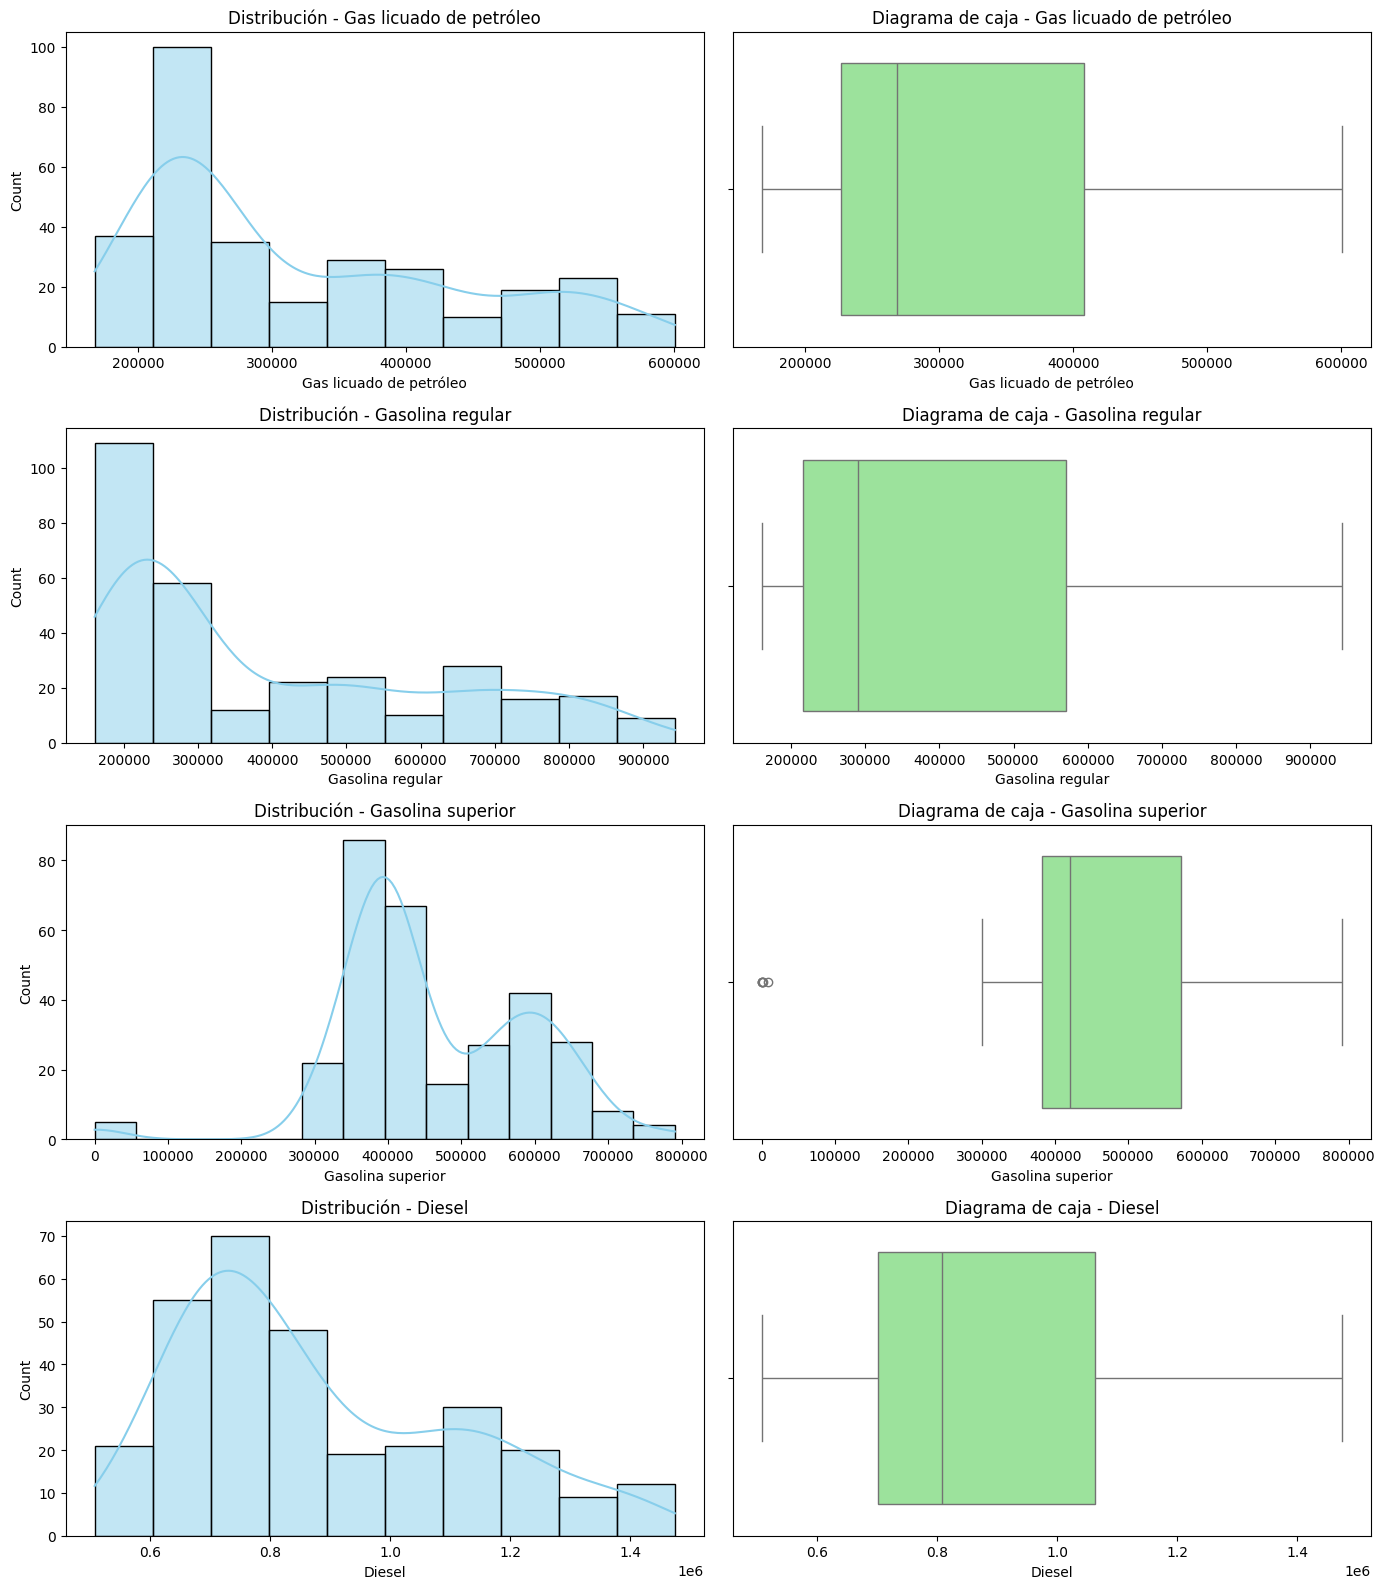

In [321]:
columnas = ['Gas licuado de petróleo', 'Gasolina regular', 'Gasolina superior', 'Diesel']
datos = df[columnas]

# Crear un diccionario para almacenar resultados
resultados = {}

# Análisis estadístico para cada variable
for col in columnas:
    valores = datos[col].dropna()
    media = np.mean(valores)
    mediana = np.median(valores)
    std = np.std(valores)
    asimetria = skew(valores)
    curtosis_val = kurtosis(valores)
    stat, p = shapiro(valores)
    
    resultados[col] = {
        'Media': media,
        'Mediana': mediana,
        'Desviación estándar': std,
        'Asimetría': asimetria,
        'Curtosis': curtosis_val,
        'Shapiro-Wilk p-valor': p
    }

# Mostrar las estadísticas
estadisticas = pd.DataFrame(resultados).T

# Graficar distribuciones y boxplots
fig, axs = plt.subplots(4, 2, figsize=(14, 16))

for i, col in enumerate(columnas):
    sns.histplot(datos[col], kde=True, ax=axs[i, 0], color='skyblue')
    axs[i, 0].set_title(f'Distribución - {col}')
    
    sns.boxplot(x=datos[col], ax=axs[i, 1], color='lightgreen')
    axs[i, 1].set_title(f'Diagrama de caja - {col}')

plt.tight_layout()
plt.show()

In [322]:
estadisticas

Media        Mediana  Desviación estándar  \
Gas licuado de petróleo  322885.822617  268875.095238        118786.556387   
Gasolina regular         402879.505696  290286.650000        221023.988459   
Gasolina superior        462617.407294  420370.600000        127220.585050   
Diesel                   880197.590733  807692.100000        231602.374826   

                         Asimetría  Curtosis  Shapiro-Wilk p-valor  
Gas licuado de petróleo   0.762418 -0.714944          1.281581e-14  
Gasolina regular          0.786103 -0.794288          1.325852e-16  
Gasolina superior        -0.205343  1.322405          6.977121e-12  
Diesel                    0.723846 -0.483713          3.763013e-11

Al ser todos los valores p menores que 0.05 se rechaza la hipotesis nula por lo que ninguna de las variables tiene normalidad.

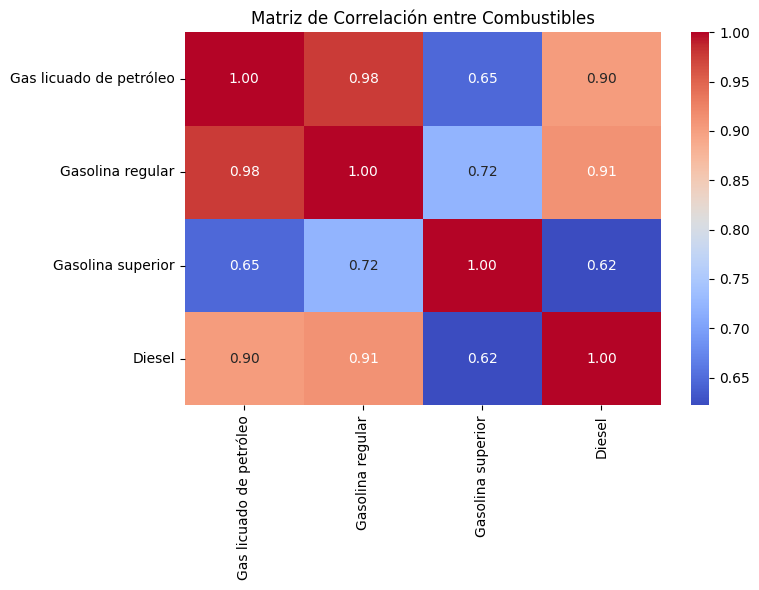

Gas licuado de petróleo  Gasolina regular  \
Gas licuado de petróleo                 1.000000          0.977199   
Gasolina regular                        0.977199          1.000000   
Gasolina superior                       0.645525          0.721148   
Diesel                                  0.903024          0.911885   

                         Gasolina superior    Diesel  
Gas licuado de petróleo           0.645525  0.903024  
Gasolina regular                  0.721148  0.911885  
Gasolina superior                 1.000000  0.621881  
Diesel                            0.621881  1.000000

In [323]:
plt.figure(figsize=(8, 6))
correlacion = datos.corr()
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación entre Combustibles")
plt.tight_layout()
plt.show()

correlacion

Parece haber un fuerte grade de correlacion entre las variables Gas Licuado, Gasolina Regular y Diesel dado que se describen entre si con un 90% de precision por otro lado la variable Gasolina Superior no esta tan fuertemente relacionado con estas aunque si guarda cierto nivel de correlacion.

# Series de tiempo #

In [324]:
train_size = int(len(df) * 0.7)
train_df = df[0:train_size]
test_df = df[train_size:len(df)]

In [325]:
Gasl_df = train_df['Gas licuado de petróleo']
Gasl_df.head(10)

Gasl_df

Fecha
2000-01-01    194410.476190
2000-02-01    174710.552381
2000-03-01    189234.066667
2000-04-01    174330.607143
2000-05-01    191745.147619
                  ...      
2017-05-01    377542.430000
2017-06-01    378389.980000
2017-07-01    369996.240000
2017-08-01    385885.050000
2017-09-01    378419.910000
Name: Gas licuado de petróleo, Length: 213, dtype: float64

In [326]:
Gasr_df = train_df['Gasolina regular']
Gasr_df.head(10)

Fecha
2000-01-01    202645.20
2000-02-01    205530.96
2000-03-01    229499.56
2000-04-01    210680.40
2000-05-01    208164.34
2000-06-01    195088.74
2000-07-01    204556.77
2000-08-01    218388.51
2000-09-01    213906.96
2000-10-01    213606.65
Name: Gasolina regular, dtype: float64

In [327]:
Gass_df = train_df['Gasolina superior']
Gass_df.head(10)

Fecha
2000-01-01    308156.82
2000-02-01    307766.31
2000-03-01    331910.29
2000-04-01    315648.08
2000-05-01    319667.97
2000-06-01    300347.70
2000-07-01    308305.93
2000-08-01    323011.86
2000-09-01    326455.72
2000-10-01    323843.63
Name: Gasolina superior, dtype: float64

In [328]:
Gasd_df = train_df['Diesel']
Gasd_df.head(10)

Fecha
2000-01-01    634667.06
2000-02-01    642380.66
2000-03-01    699807.25
2000-04-01    586803.98
2000-05-01    656948.20
2000-06-01    570919.88
2000-07-01    576436.02
2000-08-01    593770.77
2000-09-01    590145.40
2000-10-01    641113.36
Name: Diesel, dtype: float64

# ARIMA Gas licuado #

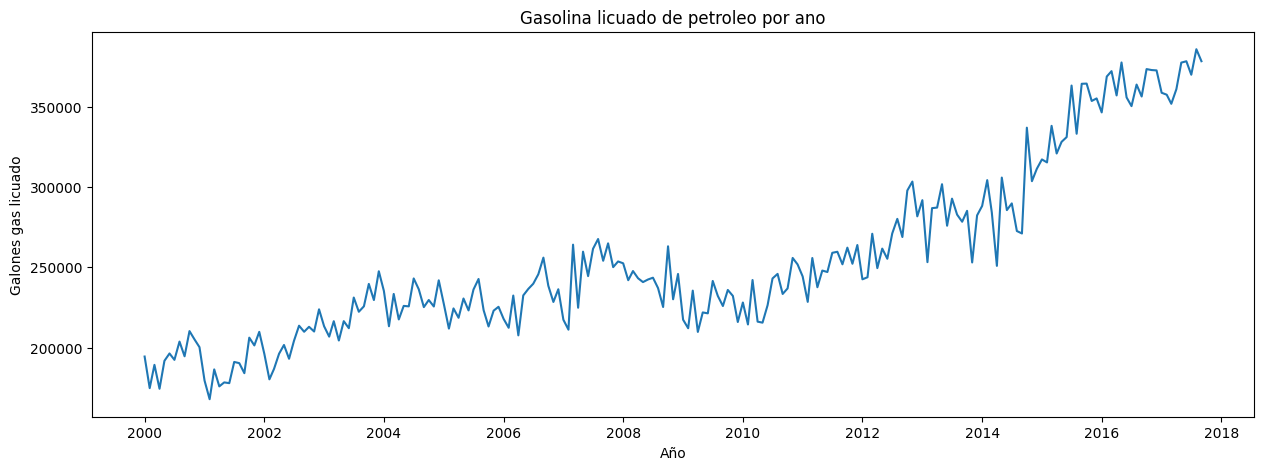

In [329]:
plt.plot(Gasl_df)
plt.gca().set(title="Gasolina licuado de petroleo por ano", xlabel="Año", ylabel="Galones gas licuado")
plt.show()

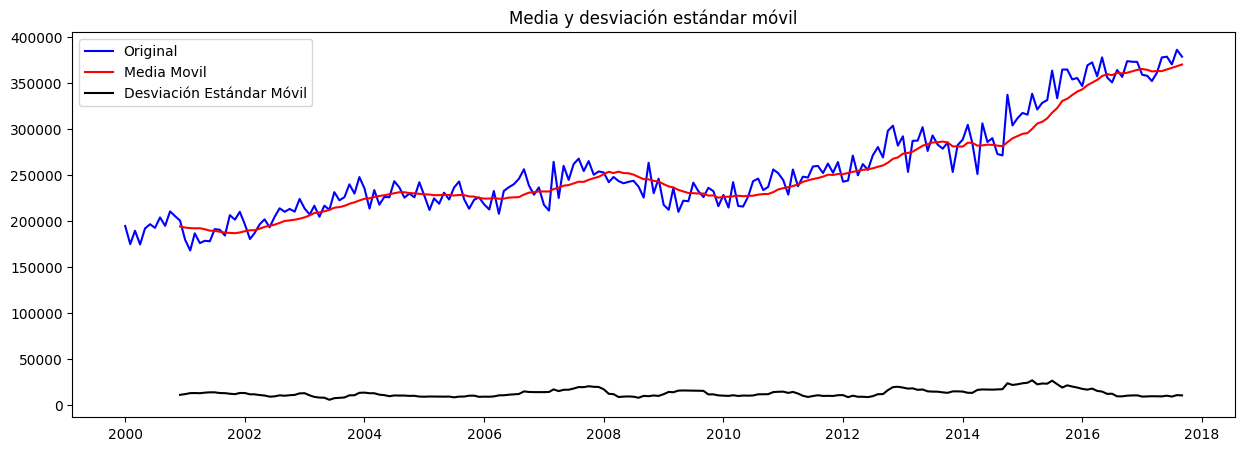

In [330]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasl_df.rolling(window=12).mean()
deMovil = Gasl_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasl_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

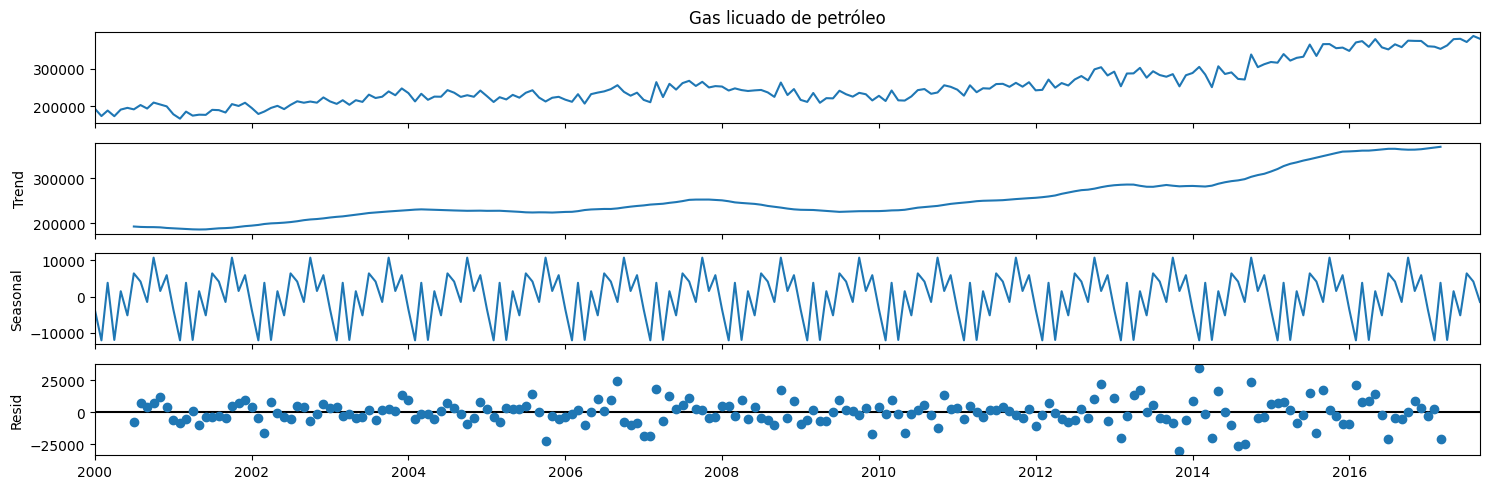

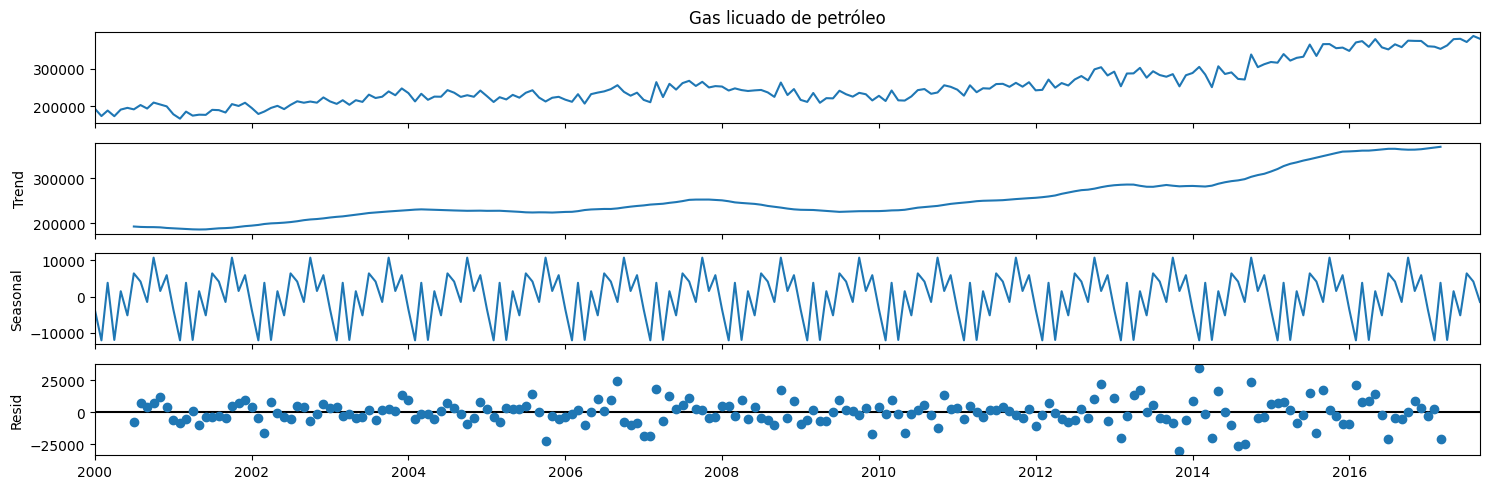

In [331]:
descomposicion = seasonal_decompose(Gasl_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

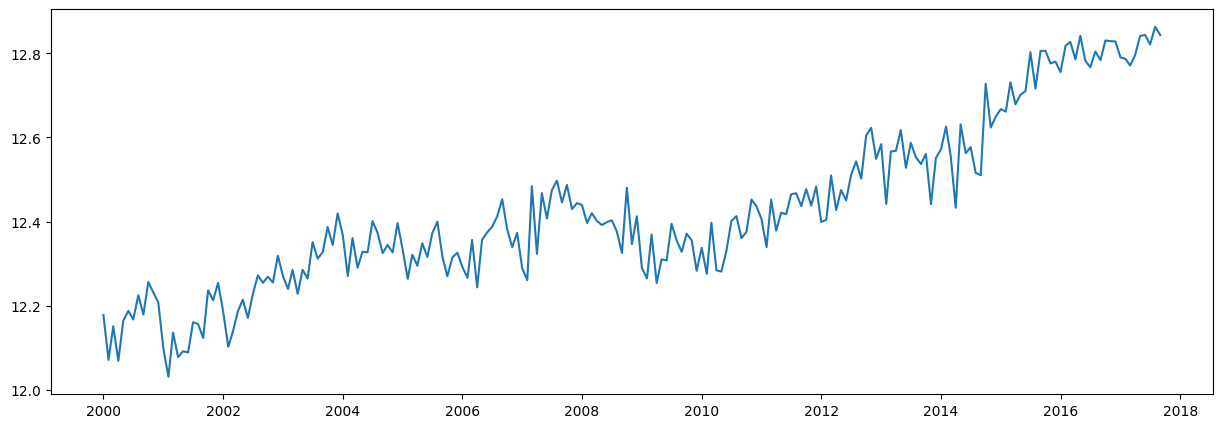

In [332]:
Gasl_df_log = np.log(Gasl_df)
plt.plot(Gasl_df_log)

Con una transformacion logaritmica la serie es estacionaria en la varianza.

In [333]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(Gasl_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.904203
p-value                        0.993145
# de retardos usados          12.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


No se puede rechazar la hipotesis nula por lo que la serie no es estacionaria en media.

In [334]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gasl_df_diff = Gasl_df.diff()
Gasl_df_diff.dropna(inplace=True)
dfTest = adfuller(Gasl_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.573267
p-value                        0.000145
# de retardos usados          11.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


El valor p es menor que 0.05 por lo que se rechaza la hipotesis nula por lo que no hay raices unitarias y se estacionarizo la serie en la media con una diferenciacion.

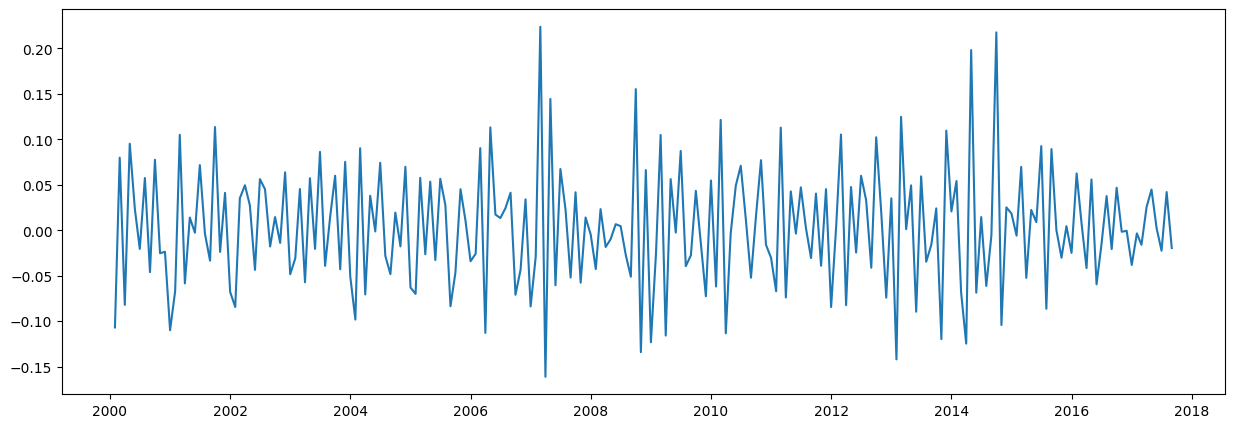

In [335]:
plt.plot(Gasl_df_log.diff())

In [402]:
Gasl_df_log_diff = Gasl_df_log.diff()
Gasl_df_log_diff.dropna(inplace = True)
tsa_acf = acf(Gasl_df_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(Gasl_df_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.52114053,  0.12269859, -0.03295786, -0.10514447,
        0.28738153])

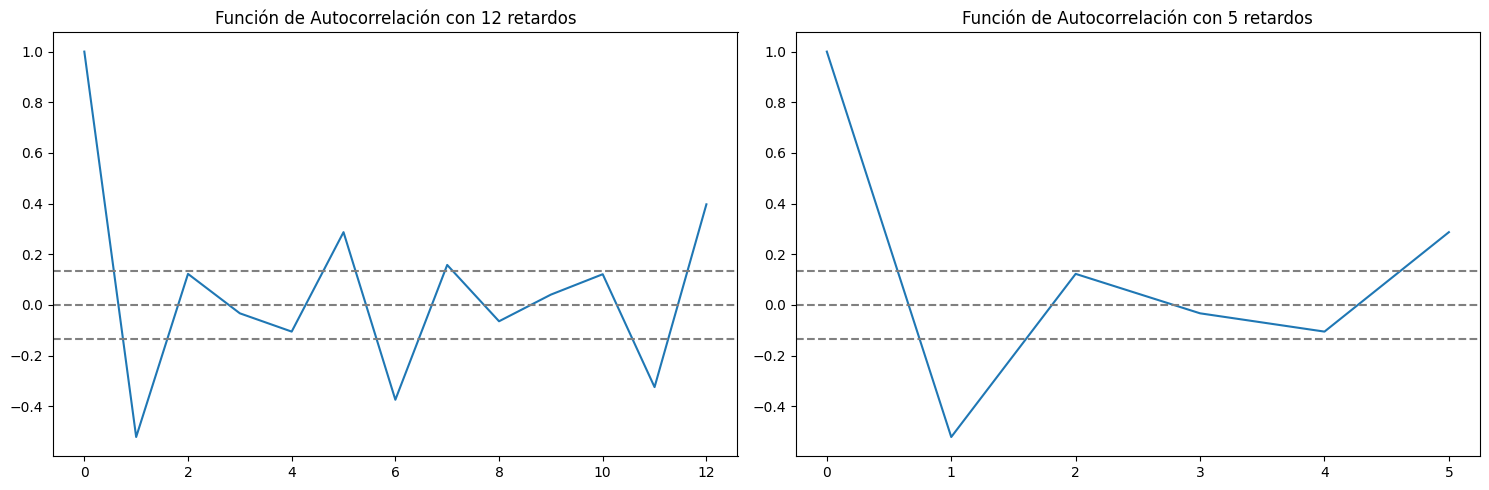

In [403]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(Gasl_df_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(Gasl_df_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

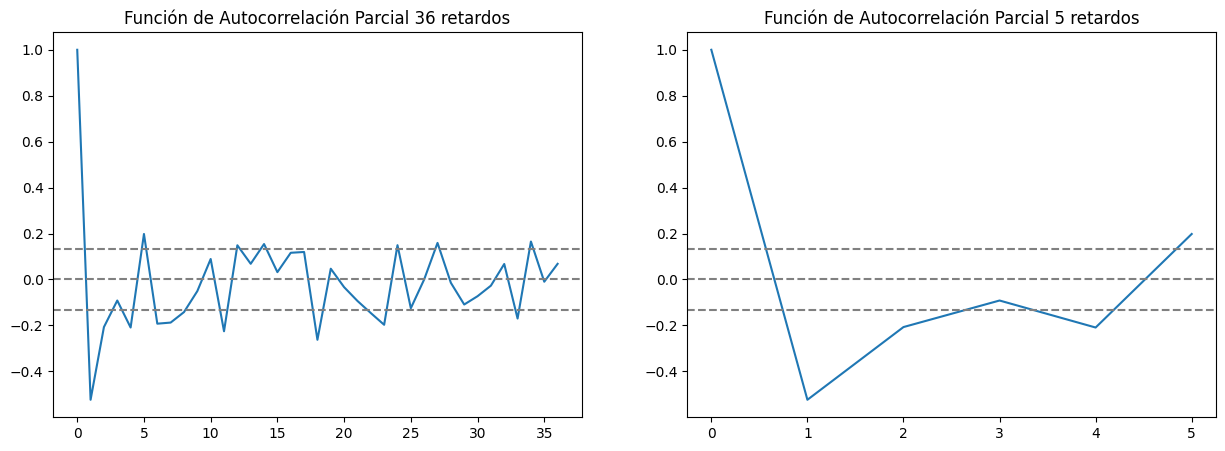

In [404]:
plt.subplot(121)
plt.plot(pacf(Gasl_df_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(Gasl_df_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Estacionalidad

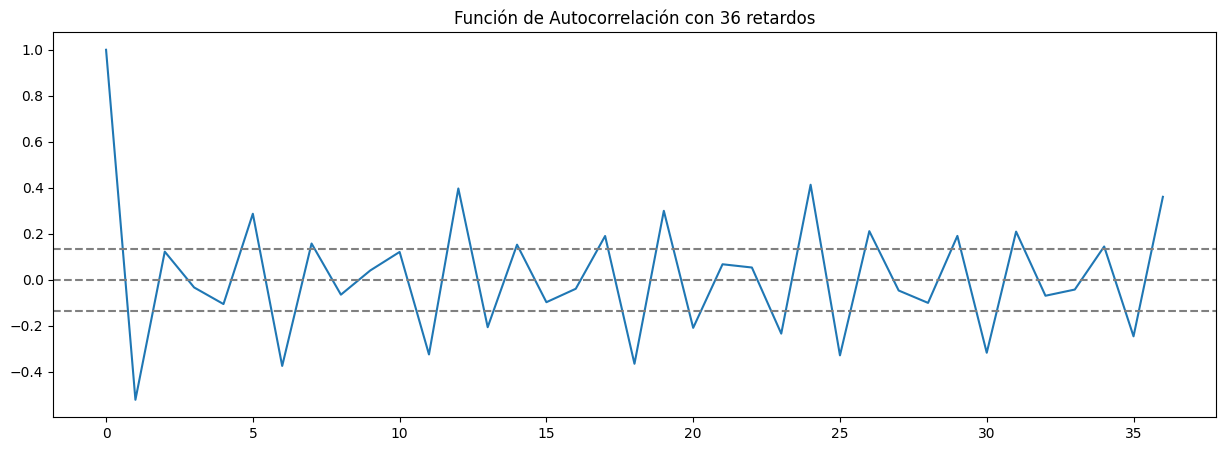

In [405]:
plt.plot(acf(Gasl_df_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Parece haber estacionalidad cada 6 meses

In [406]:
Gasl_df_log_D = Gasl_df_log.diff(6)
Gasl_df_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

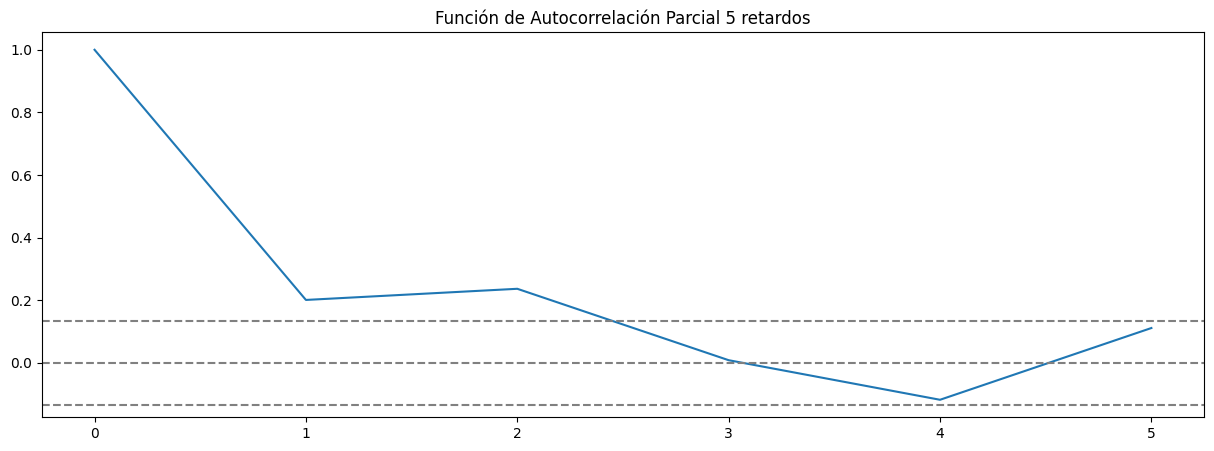

In [407]:
plt.plot(pacf(Gasl_df_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasl_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Despues de p = 2 practicamente se anulan los coeficientes

In [408]:
modelo110 = SARIMAX(Gasl_df_log, order=(1,1,0), seasonal_order=(2,1,0,6), enforce_stationarity=False, enforce_invertibility=False)
resultado_m110 = modelo110.fit()
print(resultado_m110.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4677      0.065     -7.246      0.000      -0.594      -0.341
ar.S.L6       -0.8533      0.055    -15.444      0.000      -0.962      -0.745
ar.S.L12      -0.1608      0.058     -2.778      0.005      -0.274      -0.047
sigma2         0.0036      0.000     11.309      0.000       0.003       0.004


C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


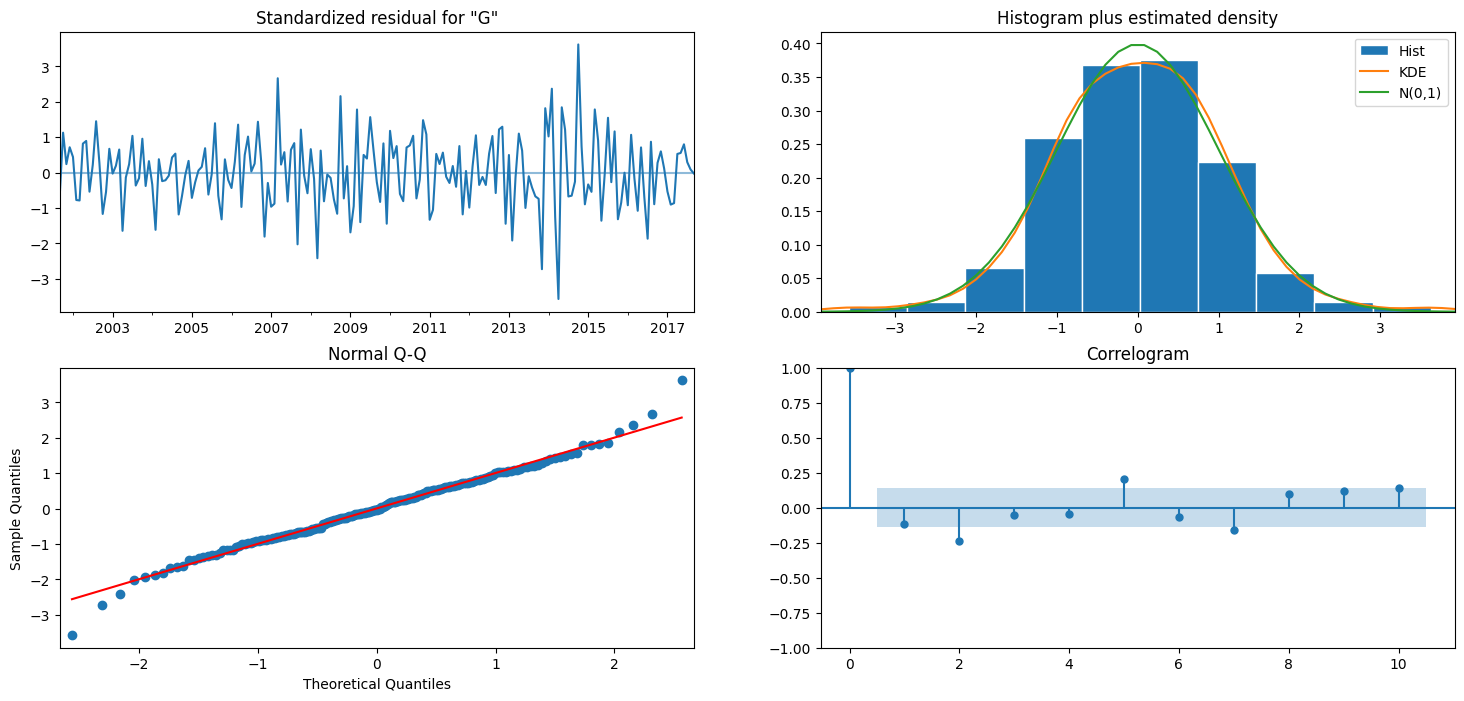

In [409]:
resultado_m110.plot_diagnostics(figsize=(18, 8))
plt.show()

In [410]:
modelo210 = SARIMAX(Gasl_df_log, order=(2,1,0), seasonal_order=(2,1,0,6), enforce_stationarity=False, enforce_invertibility=False)
resultado_m210 = modelo210.fit()
print(resultado_m210.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5827      0.076     -7.706      0.000      -0.731      -0.435
ar.L2         -0.2511      0.064     -3.945      0.000      -0.376      -0.126
ar.S.L6       -0.8462      0.057    -14.744      0.000      -0.959      -0.734
ar.S.L12      -0.1465      0.060     -2.455      0.014      -0.264      -0.030
sigma2         0.0034      0.000     11.488      0.000       0.003       0.004


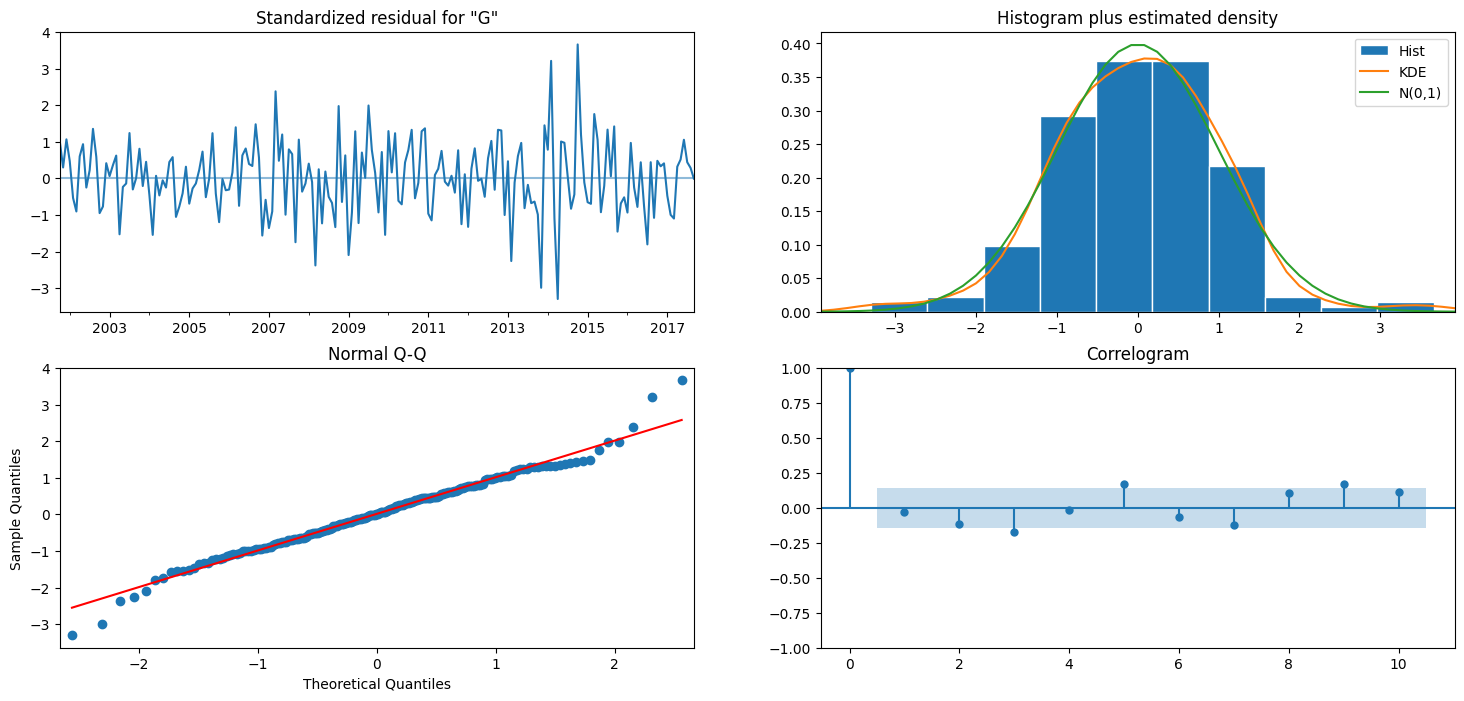

In [411]:
resultado_m210.plot_diagnostics(figsize=(18, 8))
plt.show()

In [412]:
modelo211 = SARIMAX(Gasl_df_log, order=(2,1,1), seasonal_order=(2,1,0,6), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = modelo211.fit()
print(resultado_m211.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0423      0.154     -0.274      0.784      -0.345       0.260
ar.L2         -0.0170      0.096     -0.178      0.859      -0.205       0.171
ma.L1         -0.6080      0.126     -4.815      0.000      -0.855      -0.361
ar.S.L6       -0.8167      0.060    -13.665      0.000      -0.934      -0.700
ar.S.L12      -0.1078      0.062     -1.740      0.082      -0.229       0.014
sigma2         0.0032      0.000     11.303      0.000       0.003       0.004


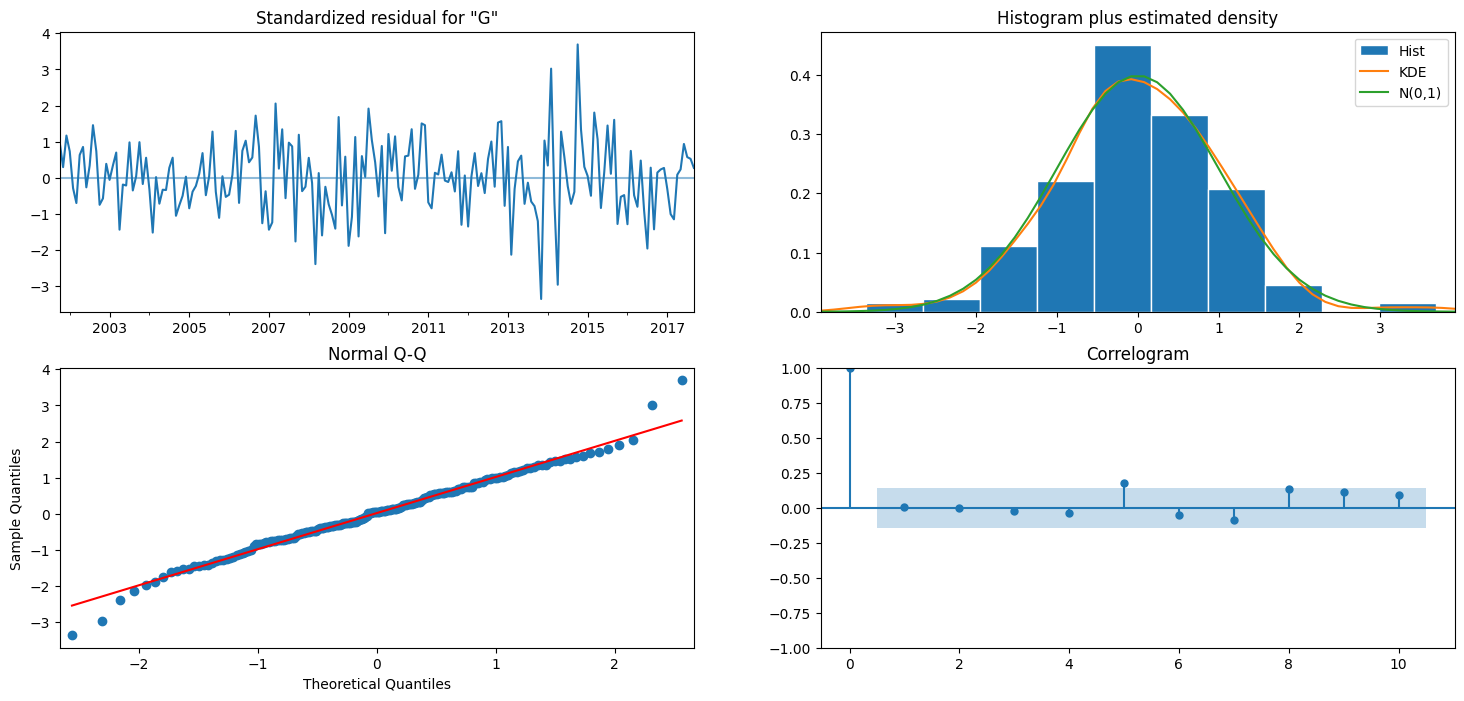

In [413]:
resultado_m211.plot_diagnostics(figsize=(18, 8))
plt.show()

In [414]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 110=",resultado_m110.aic)
print("Modelo 210=",resultado_m210.aic)
print("Modelo 211=",resultado_m211.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 110=",resultado_m110.bic)
print("Modelo 210=",resultado_m210.bic)
print("Modelo 211=",resultado_m211.bic)

Resultados de AIC (Akaike information criterion)
Modelo 110= -531.0626100254758
Modelo 210= -538.1611942998163
Modelo 211= -544.8981137342956
Resultados de BIC (Bayesian information criterion)
Modelo 110= -518.0118492698563
Modelo 210= -521.8737174396774
Modelo 211= -525.3531415021289


Basado en los parametros el mejor modelo fue el p = 2, d = 1, q = 1.

# ARIMA Gasolina Regular #

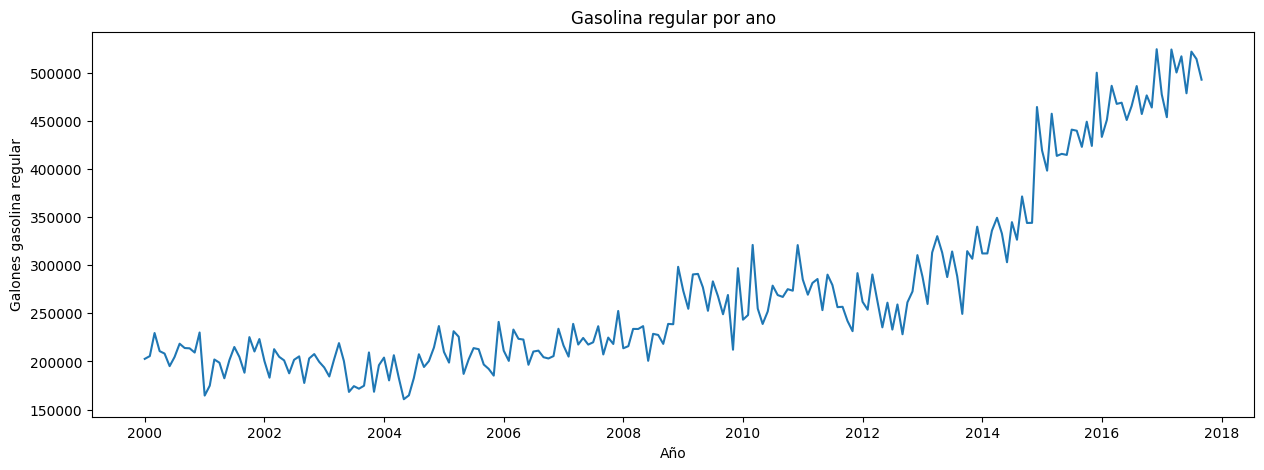

In [336]:
plt.plot(Gasr_df)
plt.gca().set(title="Gasolina regular por ano", xlabel="Año", ylabel="Galones gasolina regular")
plt.show()

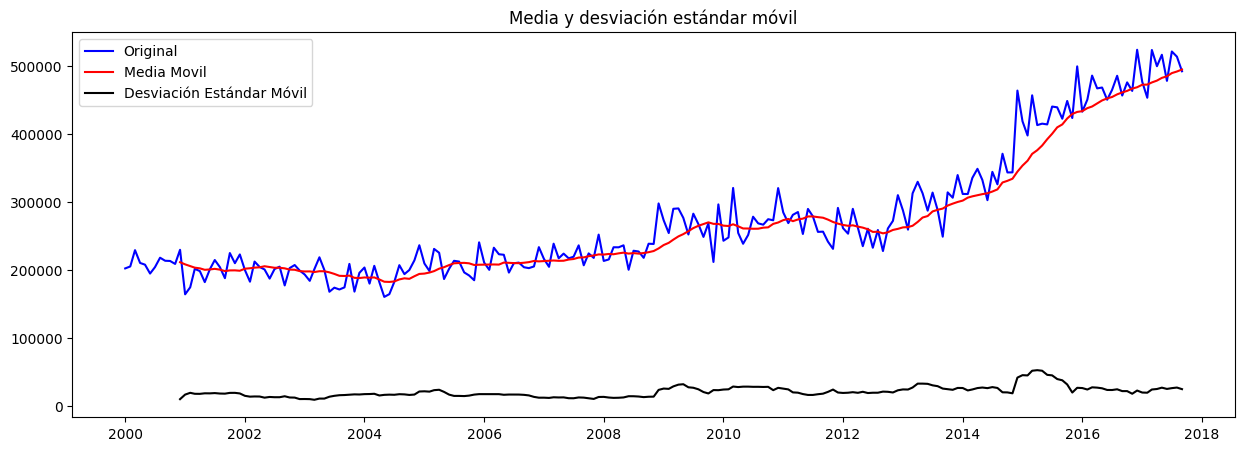

In [337]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasr_df.rolling(window=12).mean()
deMovil = Gasr_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasr_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

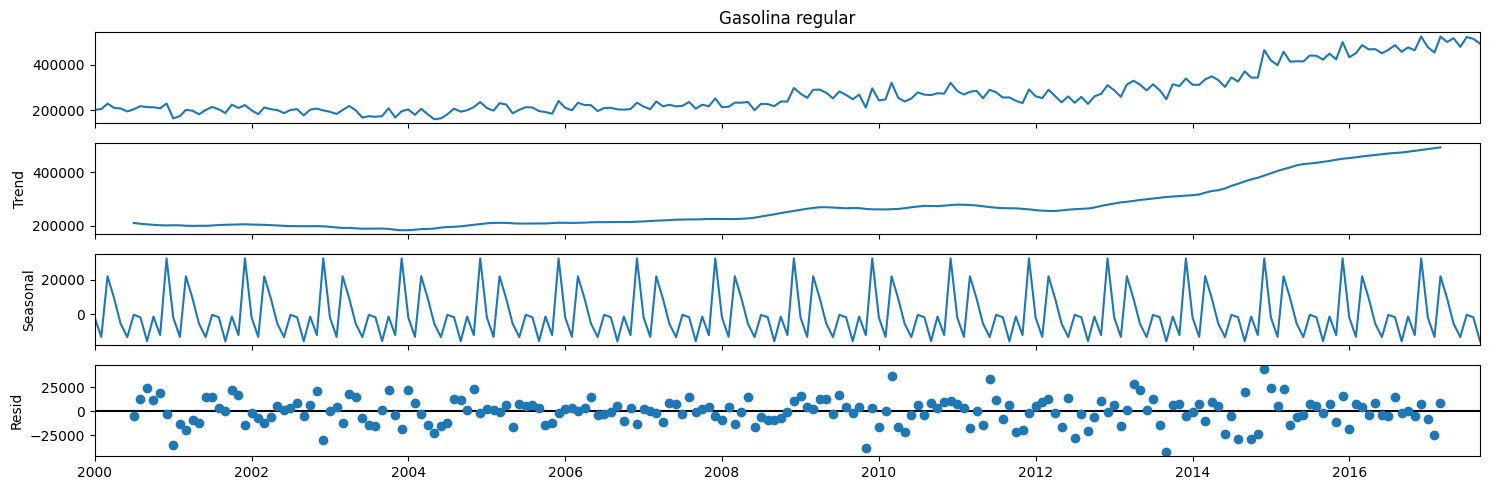

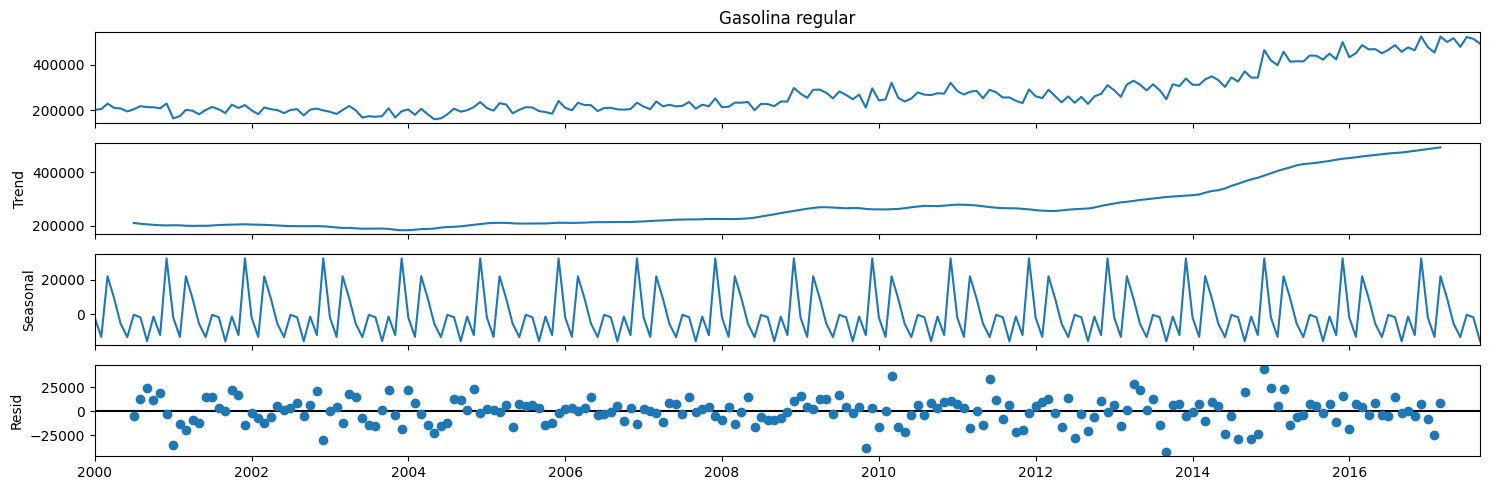

In [338]:
descomposicion = seasonal_decompose(Gasr_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

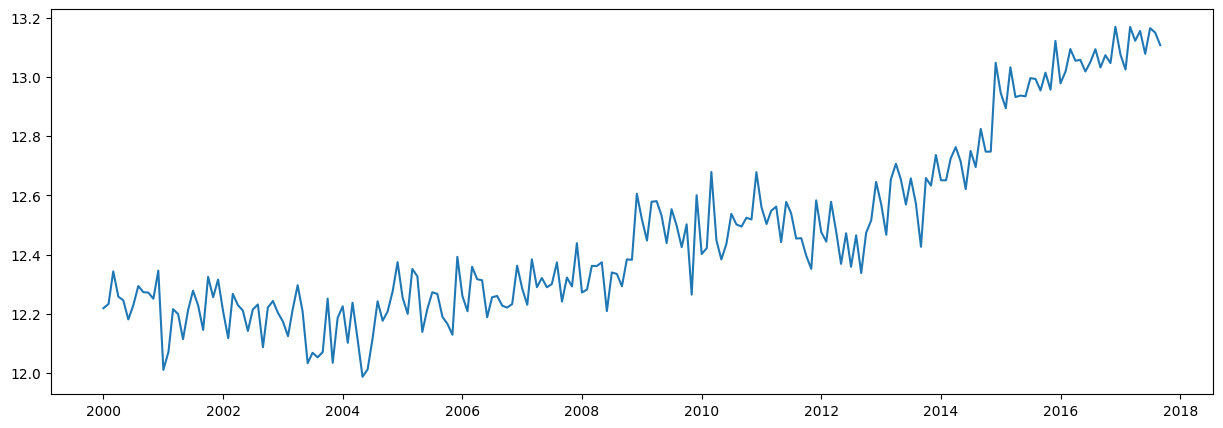

In [339]:
Gasr_df_log = np.log(Gasr_df)
plt.plot(Gasr_df_log)

Con una transformacion logaritmica la serie es estacionaria en la varianza.

In [340]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(Gasr_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          1.864621
p-value                        0.998469
# de retardos usados          12.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


No se puede rechazar la hipotesis nula

In [341]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gasr_df_diff = Gasr_df.diff()
Gasr_df_diff.dropna(inplace=True)
dfTest = adfuller(Gasr_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -3.736255
p-value                        0.003631
# de retardos usados          12.000000
# de observaciones usadas    199.000000
Critical Value (1%)           -3.463645
Critical Value (5%)           -2.876176
Critical Value (10%)          -2.574572
dtype: float64


El valor p es menor que 0.05 por lo que se rechaza la hipotesis nula por lo que no hay raices unitarias y se estacionarizo la serie en la media con una diferenciacion.

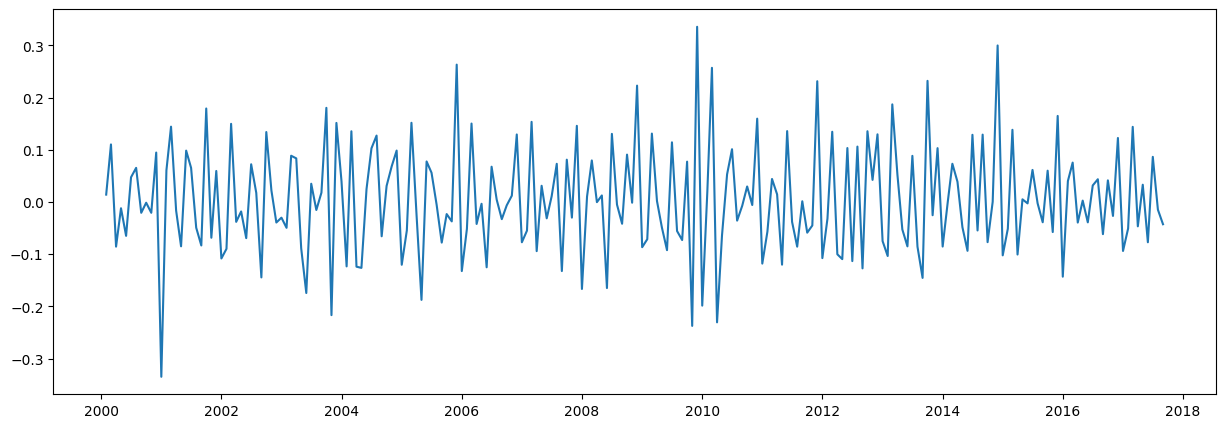

In [342]:
plt.plot(Gasr_df_log.diff())

In [343]:
Gasr_df_log_diff = Gasr_df_log.diff()
Gasr_df_log_diff.dropna(inplace = True)
tsa_acf = acf(Gasr_df_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(Gasr_df_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.42724195, -0.15236516,  0.15540517, -0.04492738,
        0.13959872])

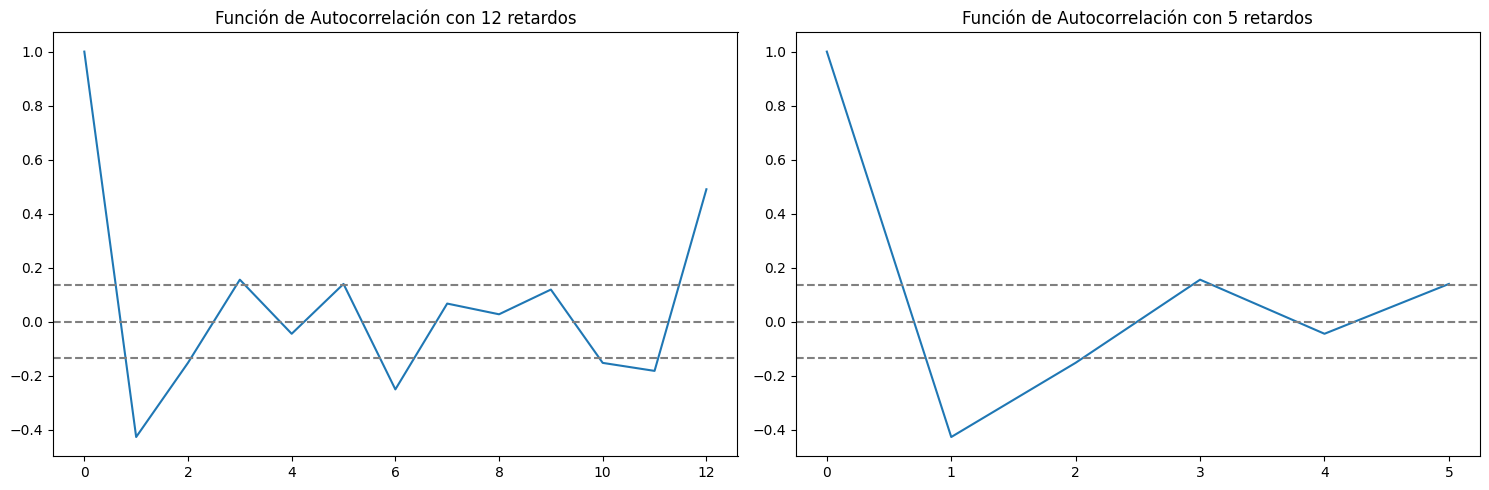

In [344]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(Gasr_df_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(Gasr_df_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

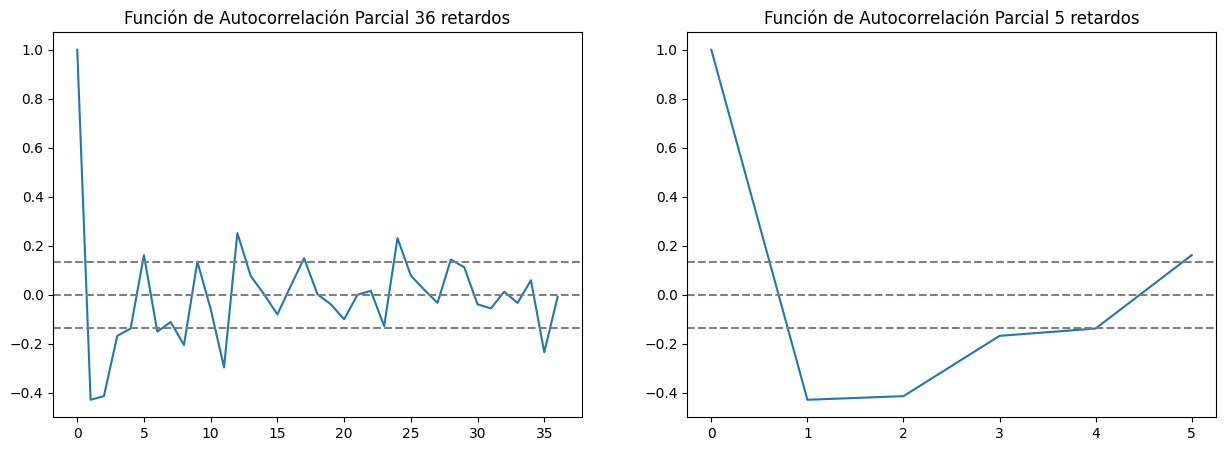

In [345]:
plt.subplot(121)
plt.plot(pacf(Gasr_df_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(Gasr_df_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Estacionalidad

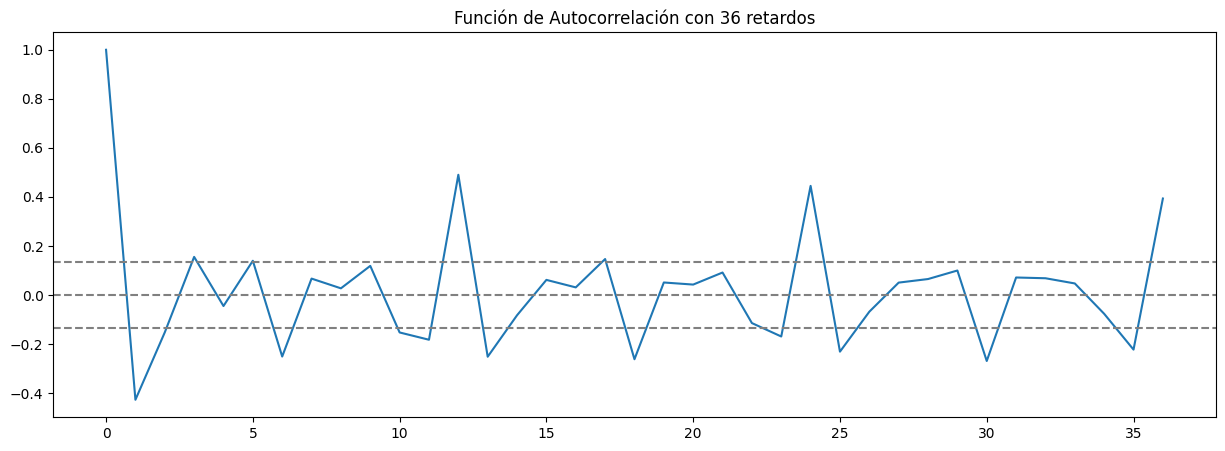

In [346]:
plt.plot(acf(Gasr_df_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Parece haber estacionalidad cada 12 meses

In [347]:
Gasr_df_log_D = Gasr_df_log.diff(12)
Gasr_df_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

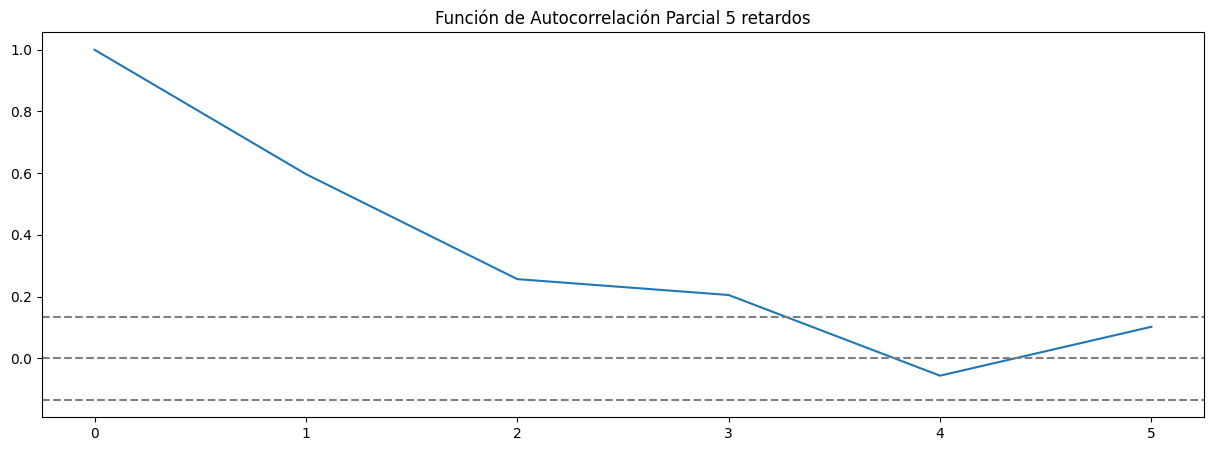

In [348]:
plt.plot(pacf(Gasr_df_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasr_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Despues de p = 3 practicamente se anulan los coeficientes

In [395]:
modelo110 = SARIMAX(Gasr_df_log, order=(1,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m110 = modelo110.fit()
print(resultado_m110.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4366      0.069     -6.354      0.000      -0.571      -0.302
ar.S.L12      -0.7176      0.063    -11.370      0.000      -0.841      -0.594
ar.S.L24      -0.4912      0.088     -5.582      0.000      -0.664      -0.319
ar.S.L36      -0.2962      0.078     -3.789      0.000      -0.449      -0.143
sigma2         0.0052      0.001      9.079      0.000       0.004       0.006


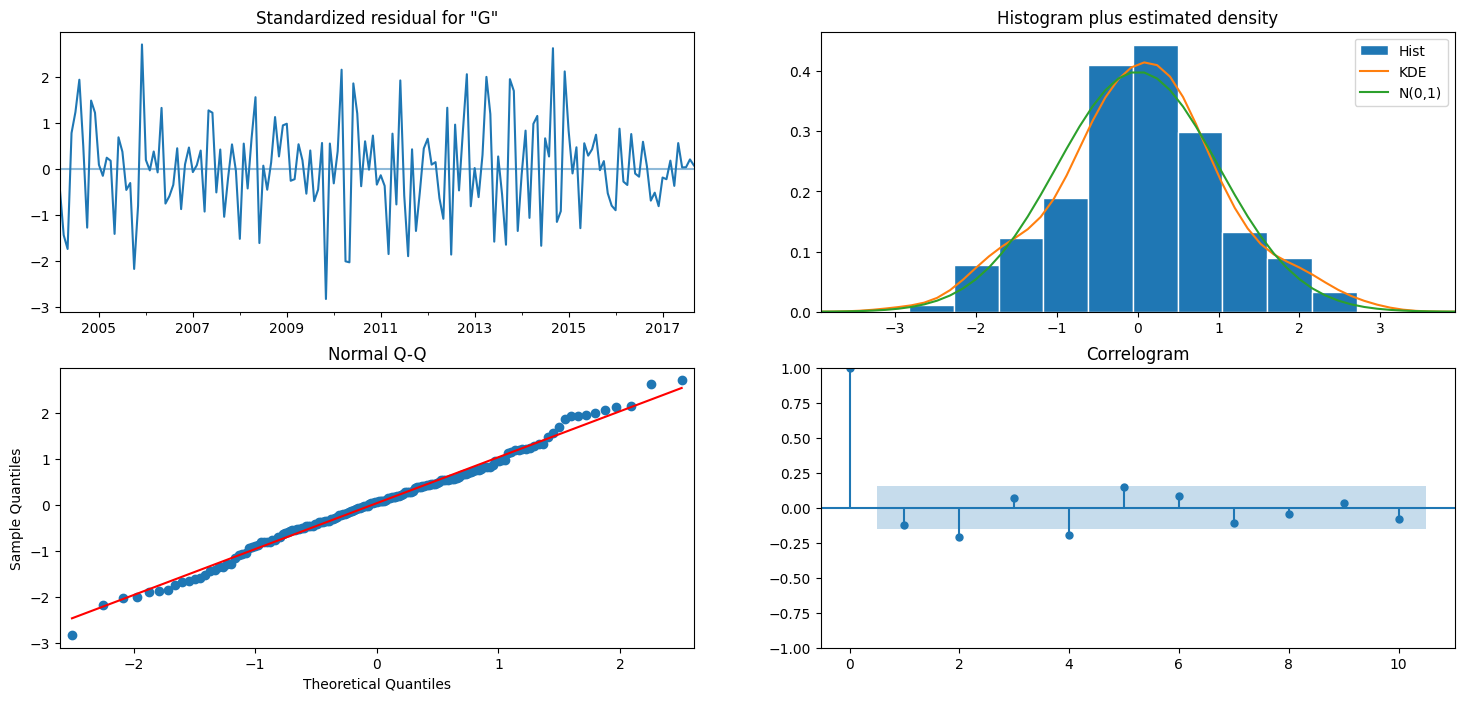

In [396]:
resultado_m110.plot_diagnostics(figsize=(18, 8))
plt.show()

In [397]:
modelo210 = SARIMAX(Gasr_df_log, order=(2,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m210 = modelo210.fit()
print(resultado_m210.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5620      0.074     -7.568      0.000      -0.708      -0.416
ar.L2         -0.2766      0.074     -3.761      0.000      -0.421      -0.132
ar.S.L12      -0.7377      0.068    -10.858      0.000      -0.871      -0.604
ar.S.L24      -0.4963      0.093     -5.328      0.000      -0.679      -0.314
ar.S.L36      -0.3086      0.083     -3.711      0.000      -0.471      -0.146
sigma2         0.0048      0.001      8.652      0.000       0.004       0.006


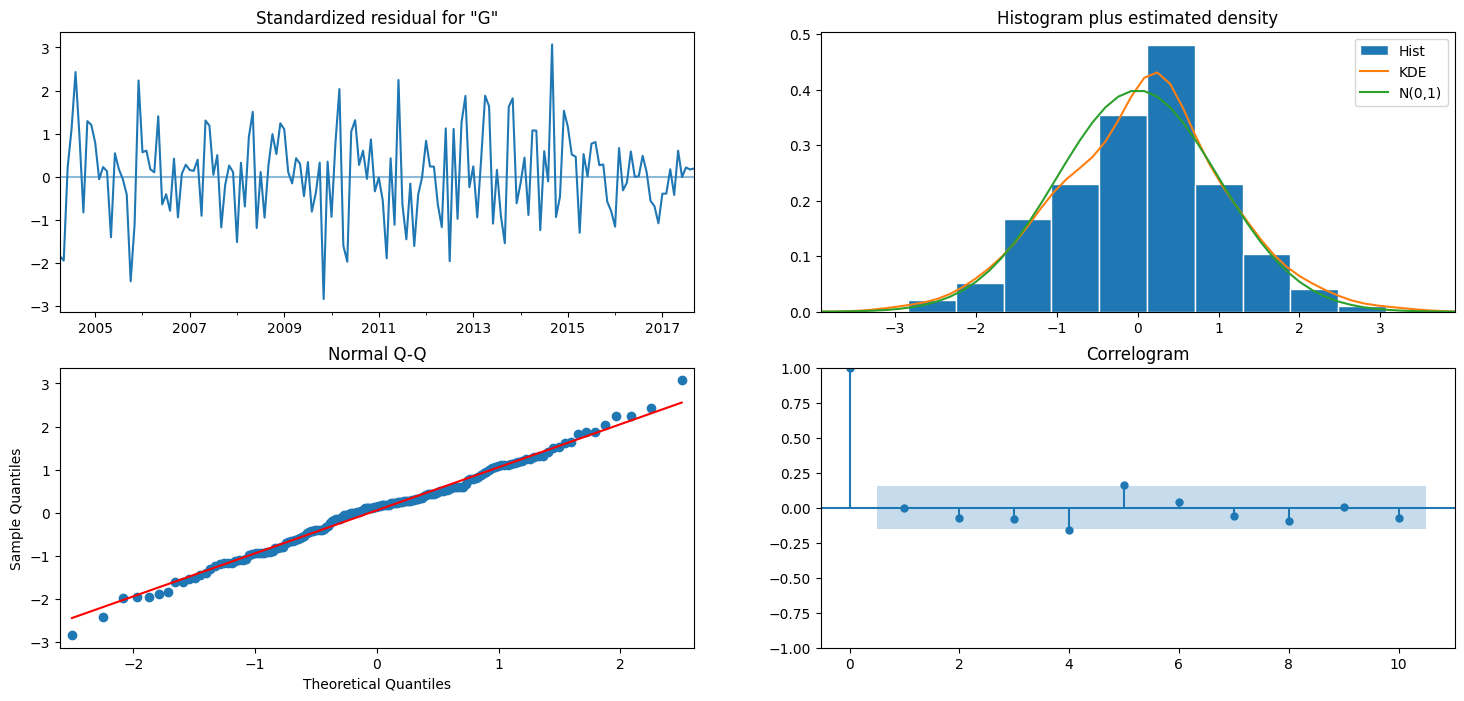

In [398]:
resultado_m210.plot_diagnostics(figsize=(18, 8))
plt.show()

In [399]:
modelo310 = SARIMAX(Gasr_df_log, order=(3,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m310 = modelo310.fit()
print(resultado_m310.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5573      0.076     -7.303      0.000      -0.707      -0.408
ar.L2         -0.2720      0.088     -3.086      0.002      -0.445      -0.099
ar.L3          0.0318      0.073      0.438      0.662      -0.111       0.174
ar.S.L12      -0.7282      0.068    -10.742      0.000      -0.861      -0.595
ar.S.L24      -0.4927      0.092     -5.329      0.000      -0.674      -0.311
ar.S.L36      -0.2970      0.083     -3.568      0.000      -0.460      -0.134
sigma2         0.0047      0.001      8.761      0.000       0.004       0.006


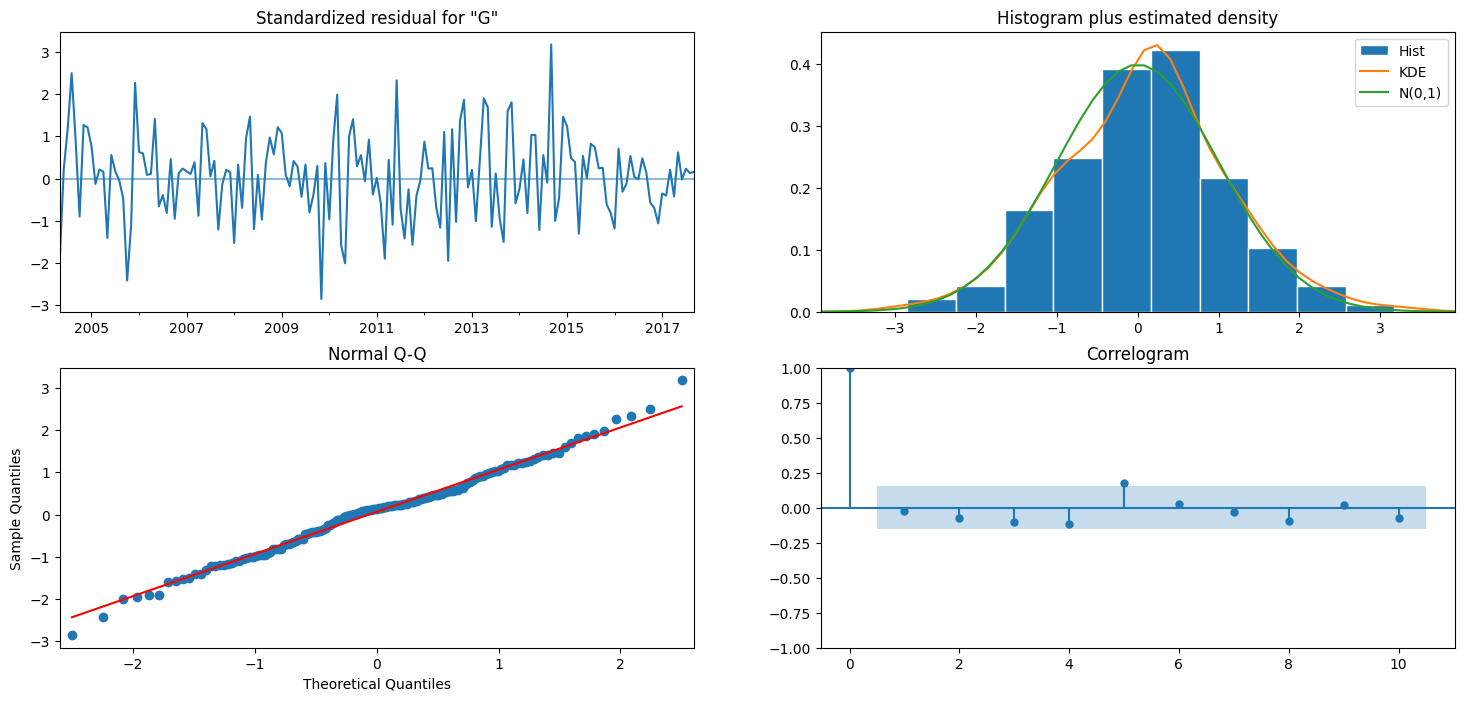

In [400]:
resultado_m310.plot_diagnostics(figsize=(18, 8))
plt.show()

In [401]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 110=",resultado_m110.aic)
print("Modelo 210=",resultado_m210.aic)
print("Modelo 310=",resultado_m310.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 110=",resultado_m110.bic)
print("Modelo 210=",resultado_m210.bic)
print("Modelo 310=",resultado_m310.bic)

Resultados de AIC (Akaike information criterion)
Modelo 110= -385.2498387624081
Modelo 210= -392.9108440147727
Modelo 310= -391.07359721732405
Resultados de BIC (Bayesian information criterion)
Modelo 110= -369.78108775837427
Modelo 210= -374.3852660033784
Modelo 310= -369.5037666624328


Basado en los parametros el mejor modelo parece ser p = 2 , d = 1 y q = 0.

# ARIMA Gasolina super #

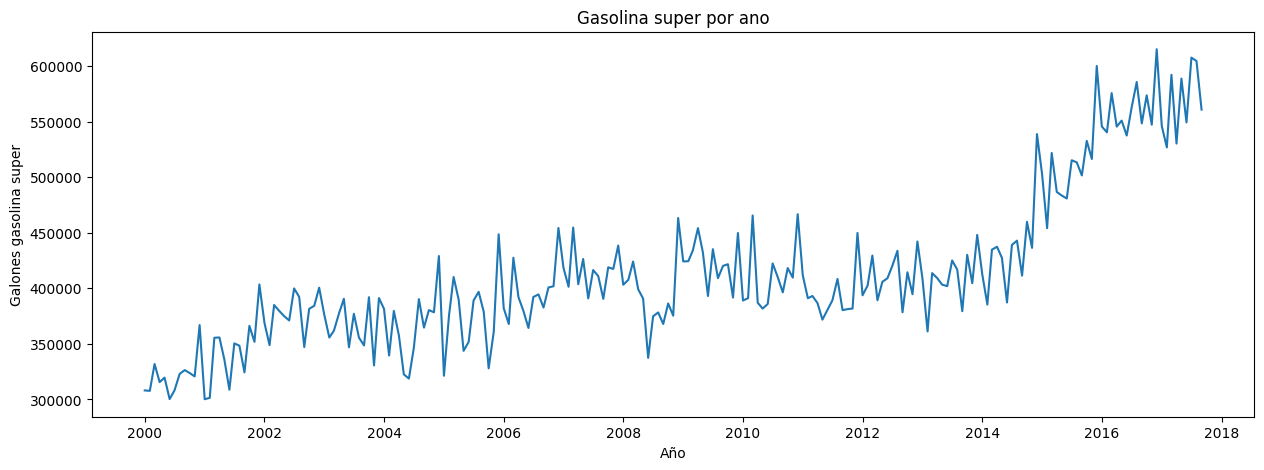

In [356]:
plt.plot(Gass_df)
plt.gca().set(title="Gasolina super por ano", xlabel="Año", ylabel="Galones gasolina super")
plt.show()

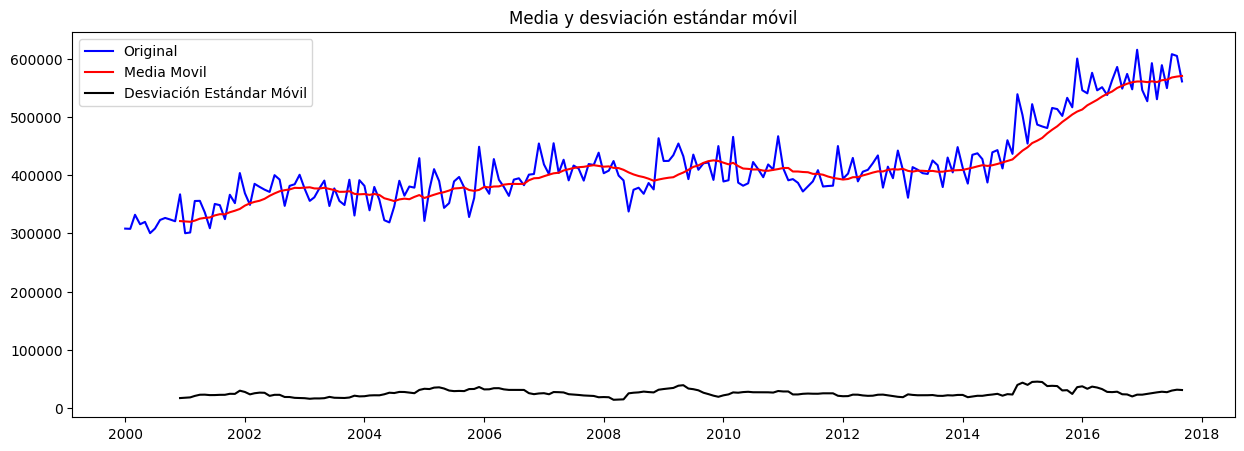

In [357]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gass_df.rolling(window=12).mean()
deMovil = Gass_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gass_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

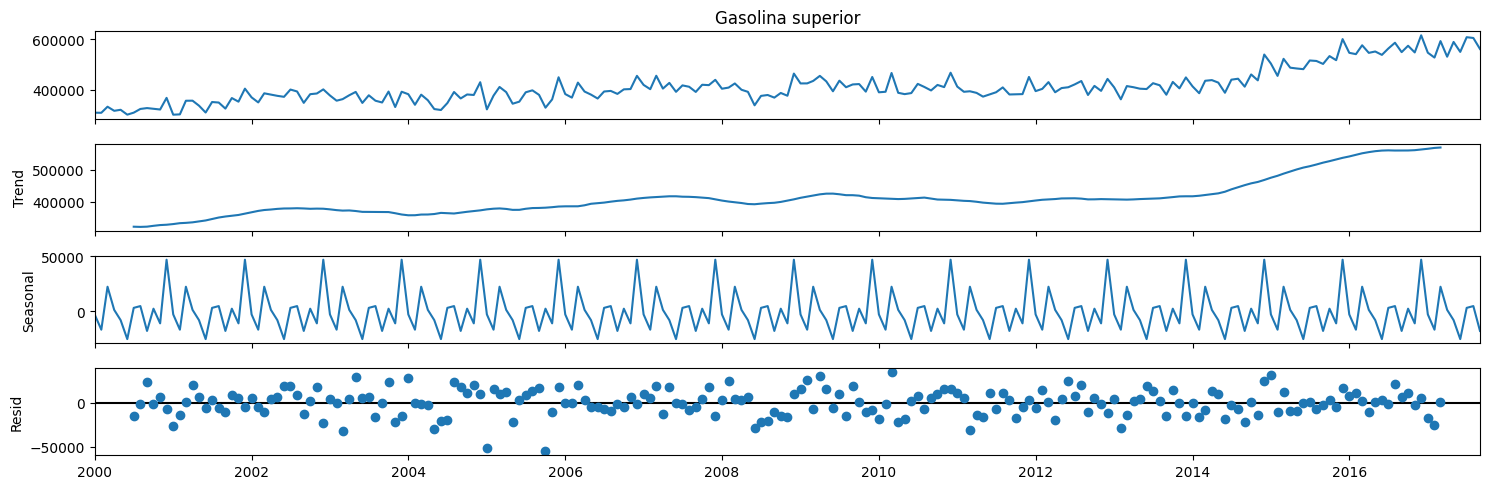

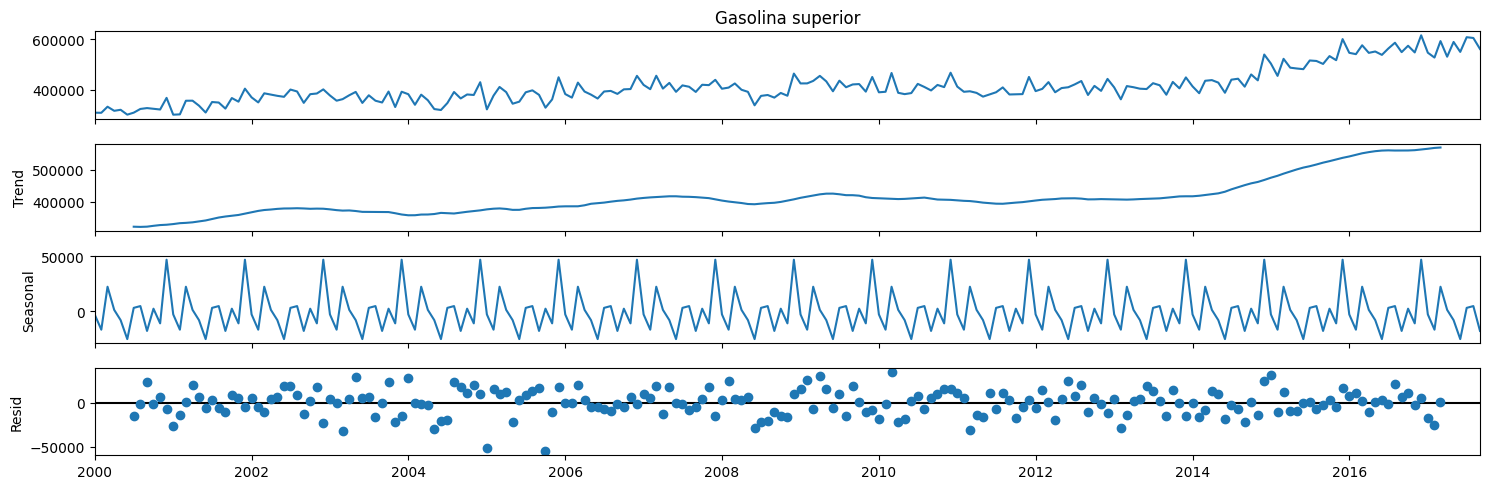

In [358]:
descomposicion = seasonal_decompose(Gass_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

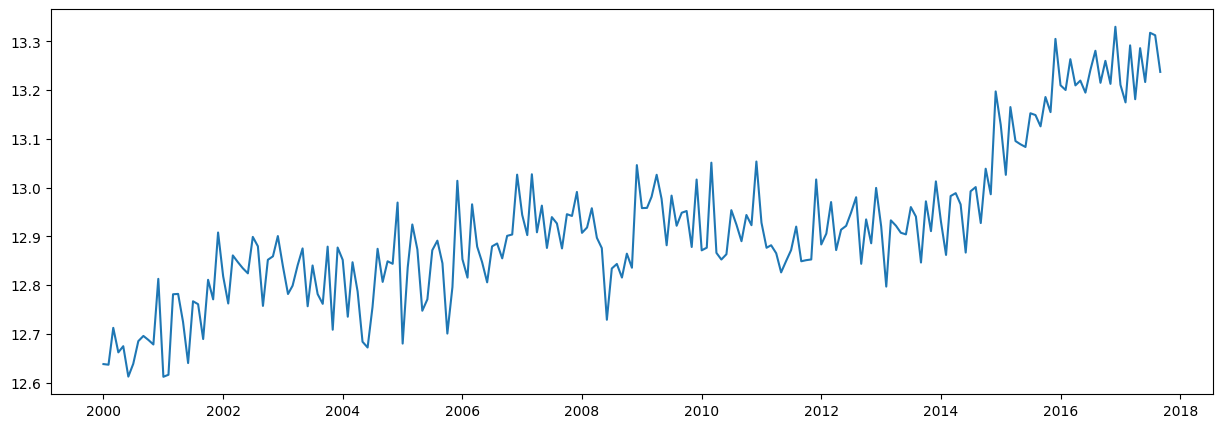

In [359]:
Gass_df_log = np.log(Gass_df)
plt.plot(Gass_df_log)

Con una transformacion logaritmica la serie es estacionaria en la varianza.

In [360]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(Gass_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          0.486218
p-value                        0.984448
# de retardos usados          12.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


No se puede rechazar la hipotesis nula.

In [361]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gass_df_diff = Gass_df.diff()
Gass_df_diff.dropna(inplace=True)
dfTest = adfuller(Gass_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.511038
p-value                        0.000188
# de retardos usados          11.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


El valor p es menor que 0.05 por lo que se rechaza la hipotesis nula por lo que no hay raices unitarias y se estacionarizo la serie en la media con una diferenciacion.

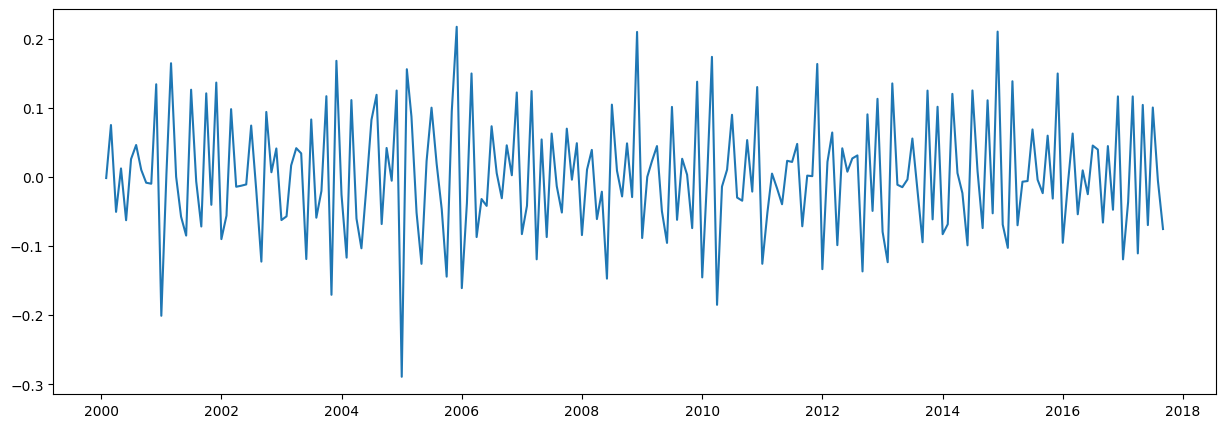

In [362]:
plt.plot(Gass_df_log.diff())

In [363]:
Gass_df_log_diff = Gass_df_log.diff()
Gass_df_log_diff.dropna(inplace = True)
tsa_acf = acf(Gass_df_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(Gass_df_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.45890201, -0.12541113,  0.1005634 , -0.00360539,
        0.2421749 ])

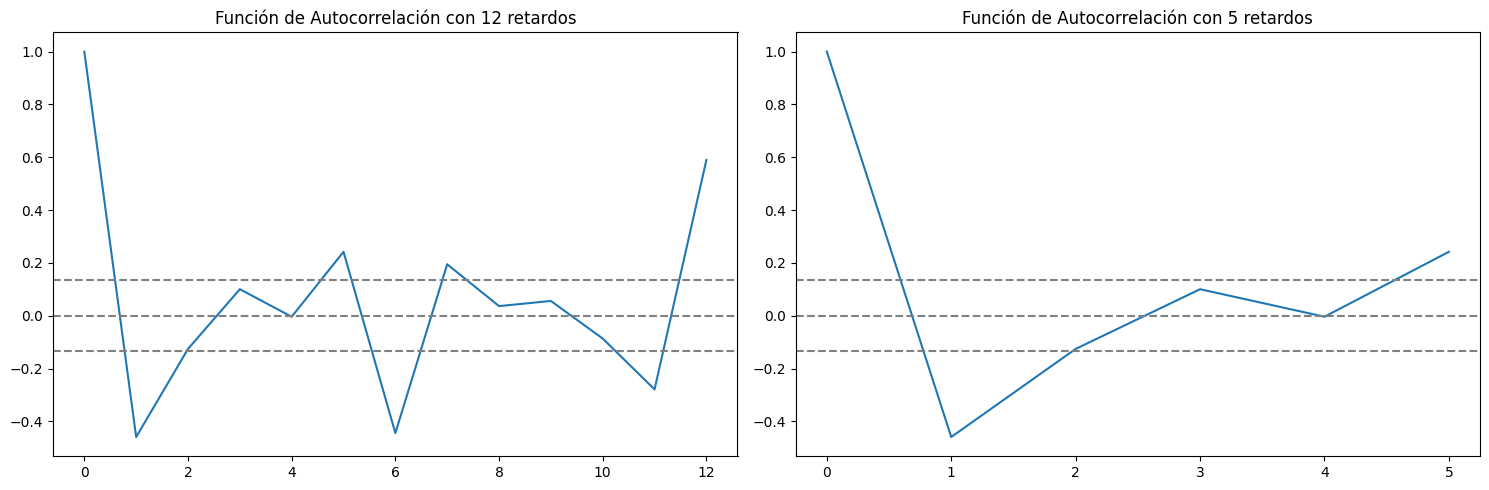

In [364]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(Gass_df_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(Gass_df_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

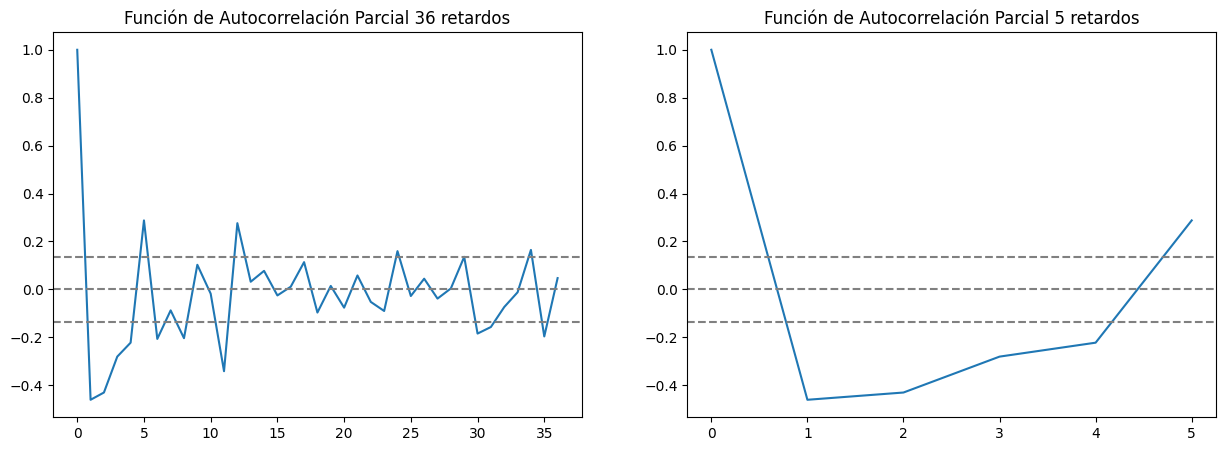

In [365]:
plt.subplot(121)
plt.plot(pacf(Gass_df_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(Gass_df_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Estacionalidad

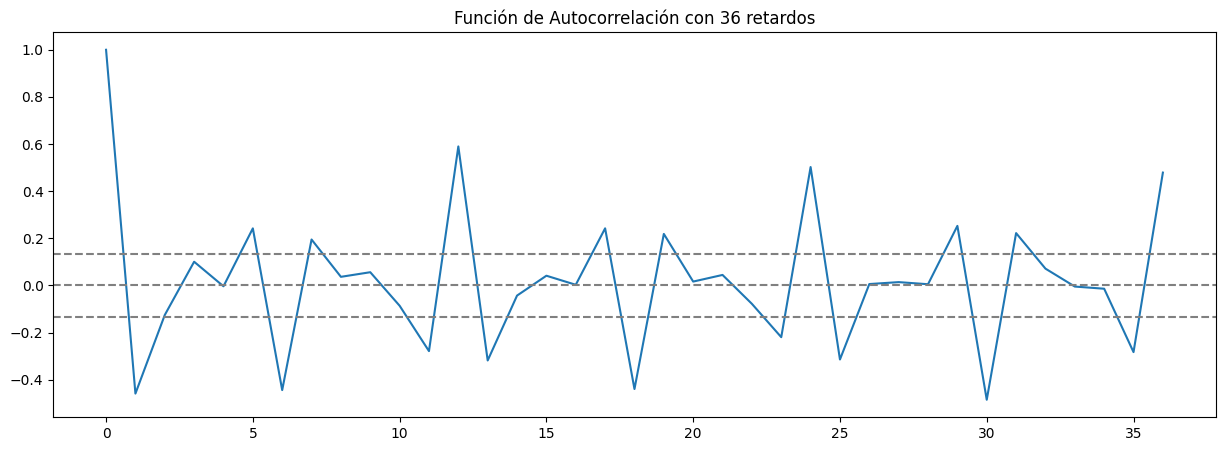

In [366]:
plt.plot(acf(Gass_df_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Parece haber estacionalidad cada 12 meses

In [367]:
Gass_df_log_D = Gass_df_log.diff(12)
Gass_df_log_D.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

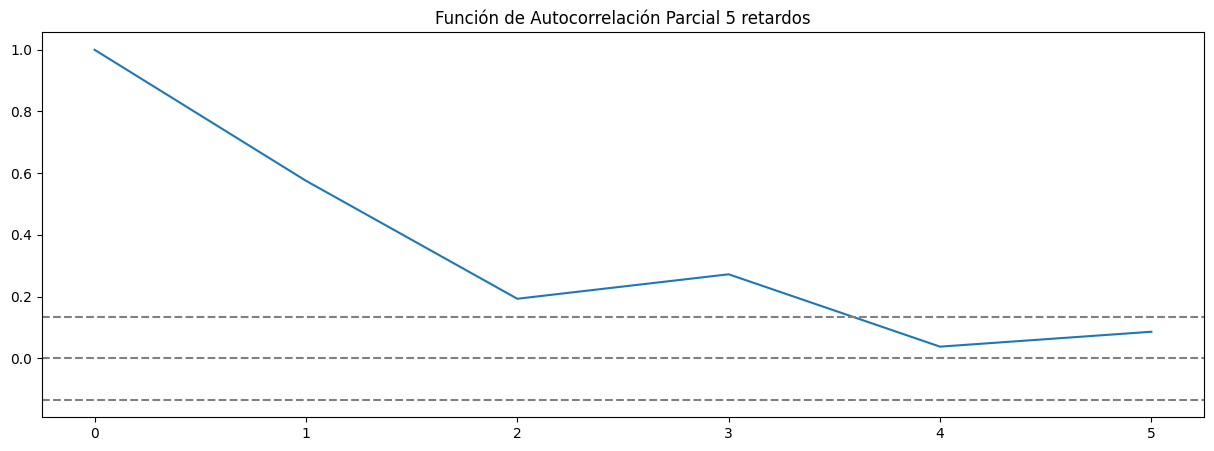

In [368]:
plt.plot(pacf(Gass_df_log_D, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gass_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Despues de p = 3 practicamente se anulan los coeficientes

In [369]:
modelo110 = SARIMAX(Gass_df_log, order=(1,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m110 = modelo110.fit()
print(resultado_m110.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3859      0.066     -5.841      0.000      -0.515      -0.256
ar.S.L12      -0.6857      0.064    -10.736      0.000      -0.811      -0.561
ar.S.L24      -0.5384      0.088     -6.117      0.000      -0.711      -0.366
ar.S.L36      -0.3173      0.064     -4.920      0.000      -0.444      -0.191
sigma2         0.0031      0.000     12.219      0.000       0.003       0.004


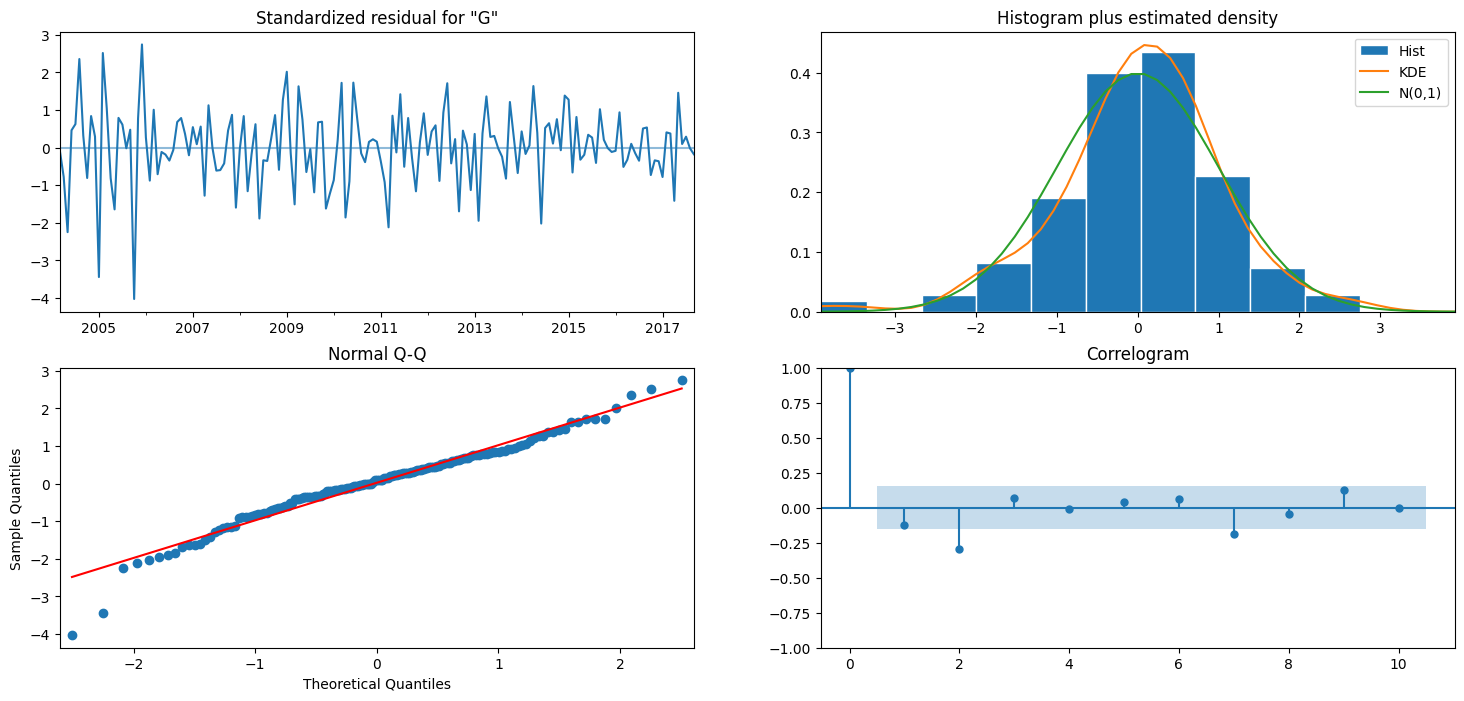

In [370]:
resultado_m110.plot_diagnostics(figsize=(18, 8))
plt.show()

In [371]:
modelo210 = SARIMAX(Gass_df_log, order=(2,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m210 = modelo210.fit()
print(resultado_m210.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5139      0.079     -6.490      0.000      -0.669      -0.359
ar.L2         -0.3205      0.075     -4.247      0.000      -0.468      -0.173
ar.S.L12      -0.7074      0.069    -10.229      0.000      -0.843      -0.572
ar.S.L24      -0.5493      0.100     -5.470      0.000      -0.746      -0.352
ar.S.L36      -0.3103      0.066     -4.690      0.000      -0.440      -0.181
sigma2         0.0028      0.000     12.130      0.000       0.002       0.003


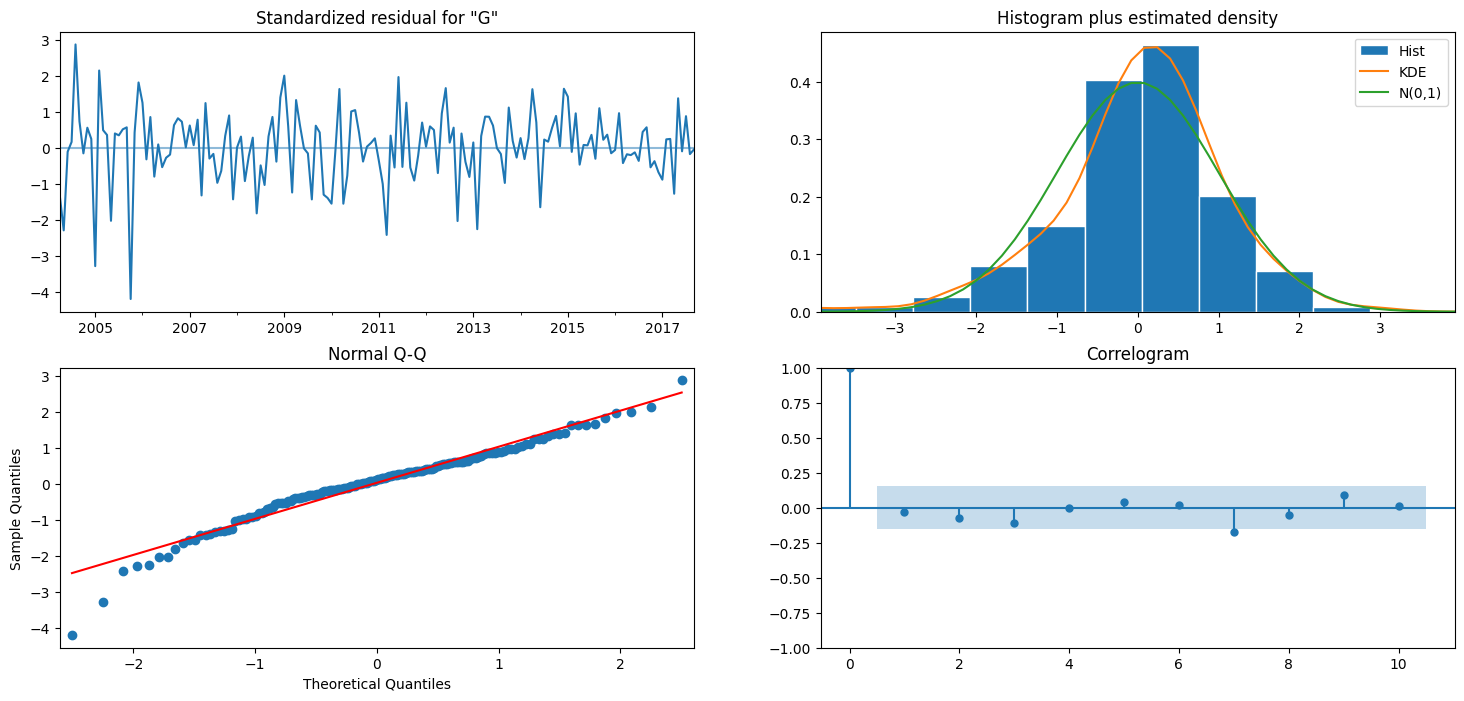

In [372]:
resultado_m210.plot_diagnostics(figsize=(18, 8))
plt.show()

In [373]:
modelo310 = SARIMAX(Gass_df_log, order=(3,1,0), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m310 = modelo310.fit()
print(resultado_m310.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5398      0.089     -6.055      0.000      -0.715      -0.365
ar.L2         -0.3713      0.100     -3.719      0.000      -0.567      -0.176
ar.L3         -0.0764      0.084     -0.907      0.364      -0.241       0.089
ar.S.L12      -0.7018      0.073     -9.589      0.000      -0.845      -0.558
ar.S.L24      -0.5451      0.102     -5.344      0.000      -0.745      -0.345
ar.S.L36      -0.3040      0.067     -4.541      0.000      -0.435      -0.173
sigma2         0.0027      0.000     11.924      0.000       0.002       0.003


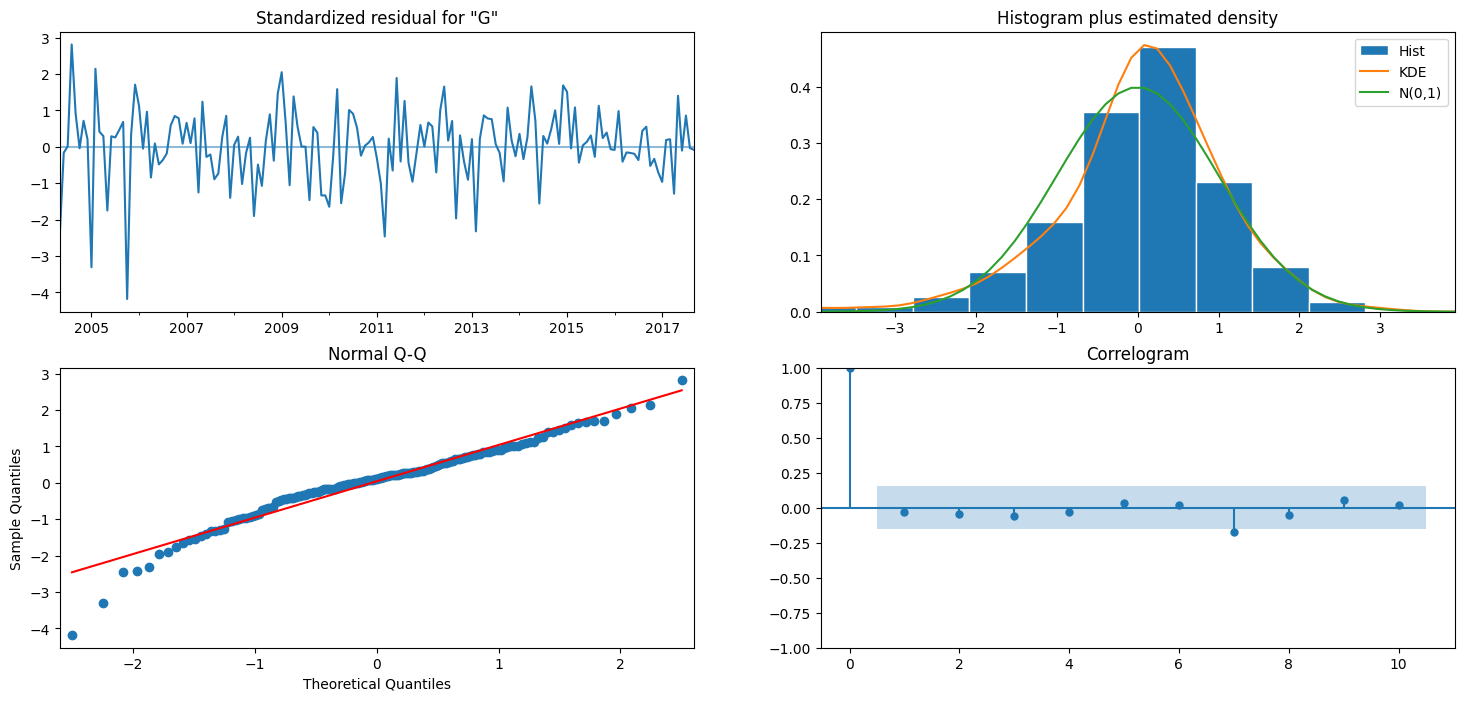

In [374]:
resultado_m310.plot_diagnostics(figsize=(18, 8))
plt.show()

In [375]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 110=",resultado_m110.aic)
print("Modelo 210=",resultado_m210.aic)
print("Modelo 310=",resultado_m310.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 110=",resultado_m110.bic)
print("Modelo 210=",resultado_m210.bic)
print("Modelo 310=",resultado_m310.bic)

Resultados de AIC (Akaike information criterion)
Modelo 110= -469.98108658856415
Modelo 210= -481.727680557193
Modelo 310= -478.4158945861979
Resultados de BIC (Bayesian information criterion)
Modelo 110= -454.5123355845303
Modelo 210= -463.2021025457987
Modelo 310= -456.8460640313067


El mejor modelo basado en los 2 parametros parece ser el p = 2, d = 1, q = 0.

# ARIMA Diesel #

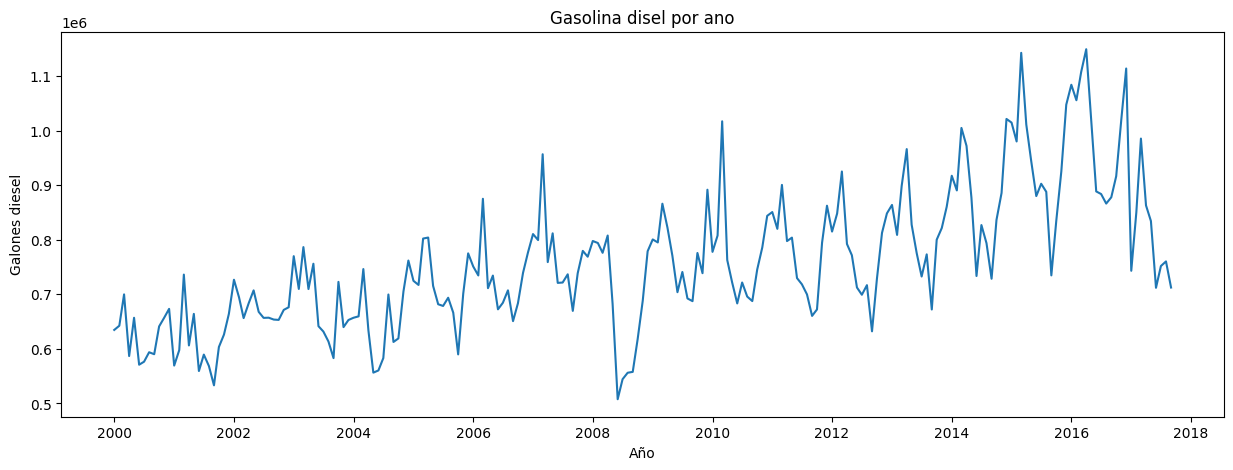

In [376]:
plt.plot(Gasd_df)
plt.gca().set(title="Gasolina disel por ano", xlabel="Año", ylabel="Galones diesel")
plt.show()

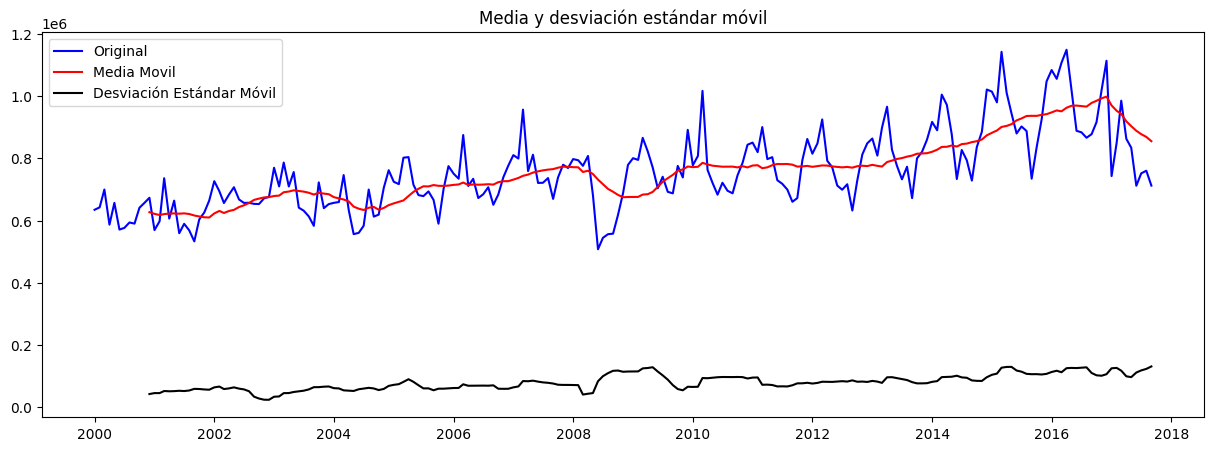

In [377]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = Gasd_df.rolling(window=12).mean()
deMovil = Gasd_df.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(Gasd_df, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

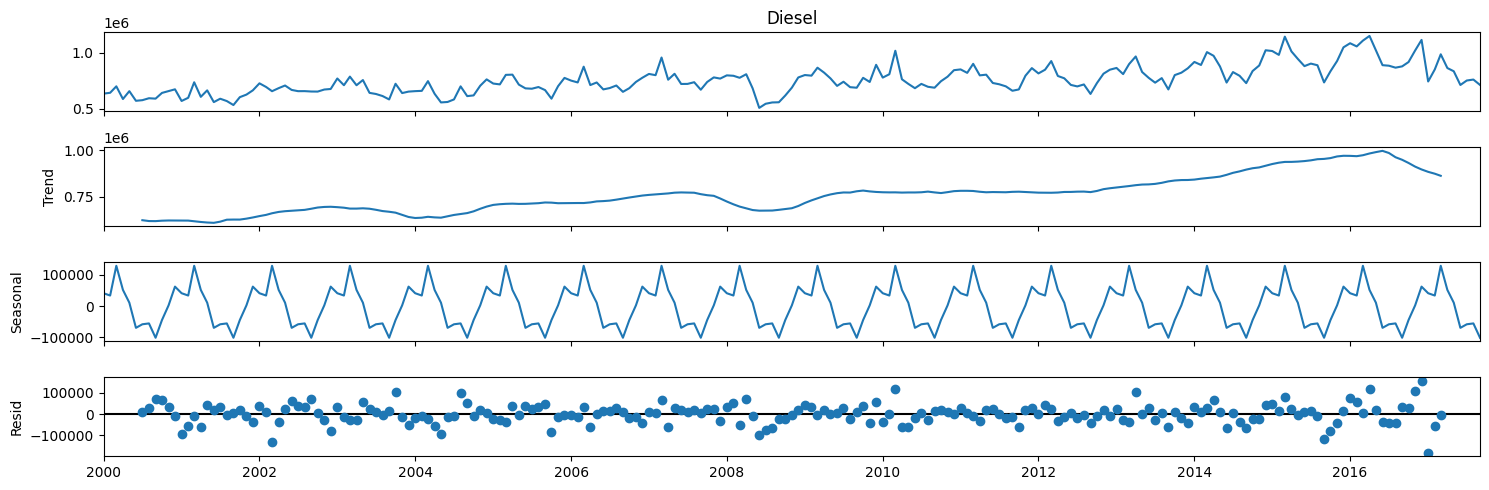

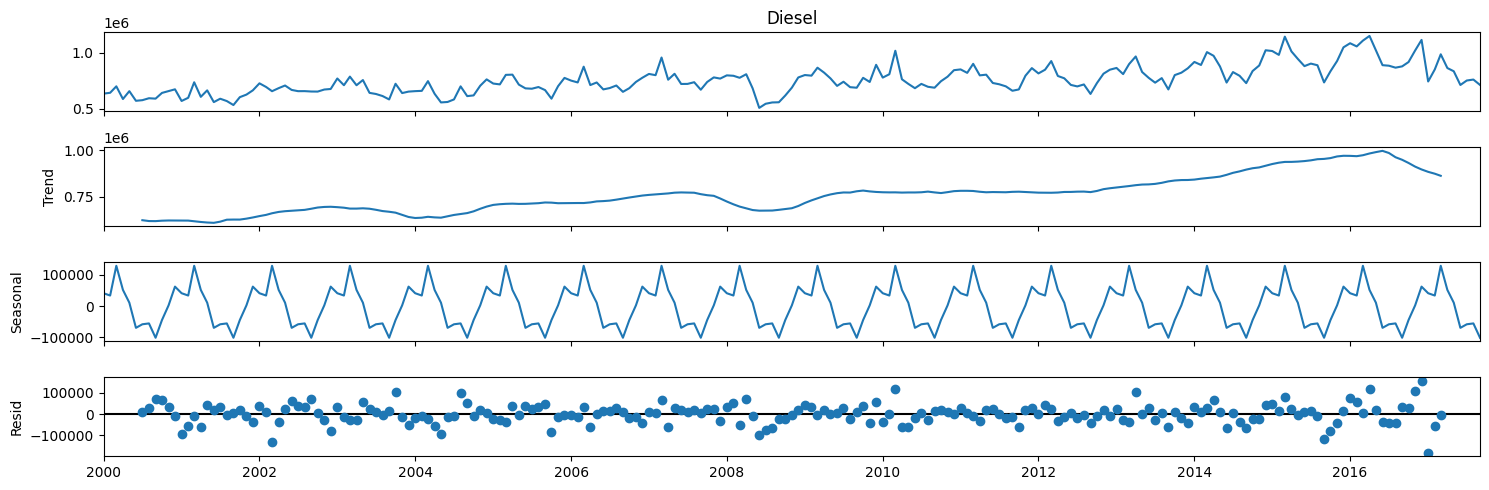

In [378]:
descomposicion = seasonal_decompose(Gasd_df)
descomposicion.plot()

Existe tendencia por lo que no parece ser estacionaria en la media ni en la varianza.

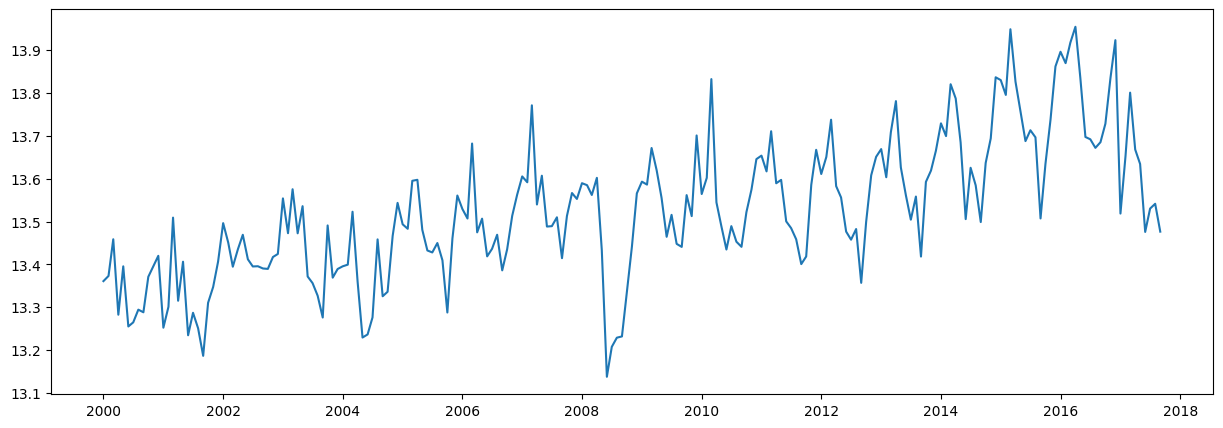

In [379]:
Gasd_df_log = np.log(Gasd_df)
plt.plot(Gasd_df_log)

Con una transformacion logaritmica la serie es estacionaria en la varianza.

In [380]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(Gasd_df, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.777528
p-value                        0.391674
# de retardos usados          14.000000
# de observaciones usadas    198.000000
Critical Value (1%)           -3.463815
Critical Value (5%)           -2.876251
Critical Value (10%)          -2.574611
dtype: float64


No se puede rechazar la hipotesis nula.

In [381]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
Gasd_df_diff = Gasd_df.diff()
Gasd_df_diff.dropna(inplace=True)
dfTest = adfuller(Gasd_df_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -5.391823
p-value                        0.000004
# de retardos usados          11.000000
# de observaciones usadas    200.000000
Critical Value (1%)           -3.463476
Critical Value (5%)           -2.876102
Critical Value (10%)          -2.574532
dtype: float64


El valor p es menor que 0.05 por lo que se rechaza la hipotesis nula por lo que no hay raices unitarias y se estacionarizo la serie en la media con una diferenciacion.

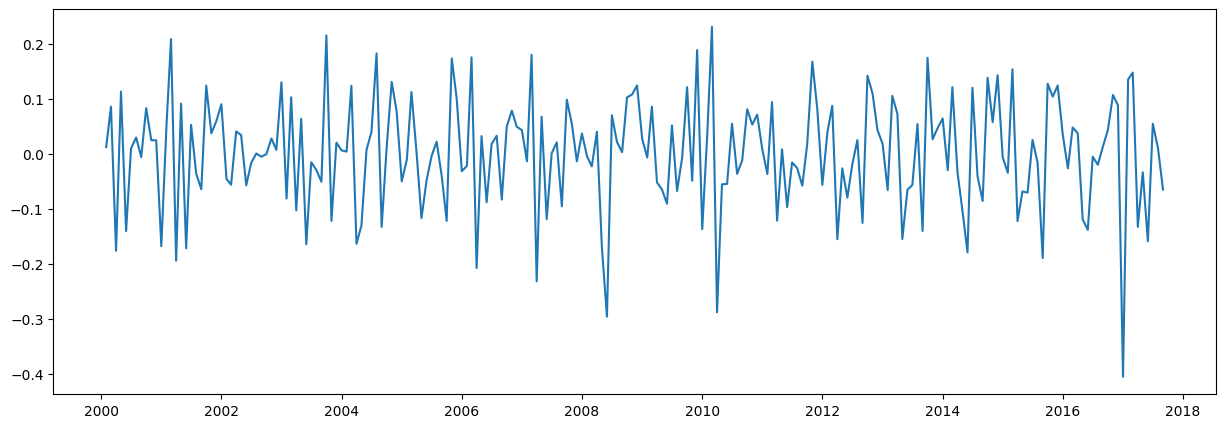

In [382]:
plt.plot(Gasd_df_log.diff())

In [383]:
Gasd_df_log_diff = Gasd_df_log.diff()
Gasd_df_log_diff.dropna(inplace = True)
tsa_acf = acf(Gasd_df_log_diff,nlags=5,fft=False)
tsa_pacf = pacf(Gasd_df_log_diff, nlags=36)
tsa_acf

array([ 1.        , -0.22454957, -0.03495529,  0.04155913, -0.07013212,
        0.07323833])

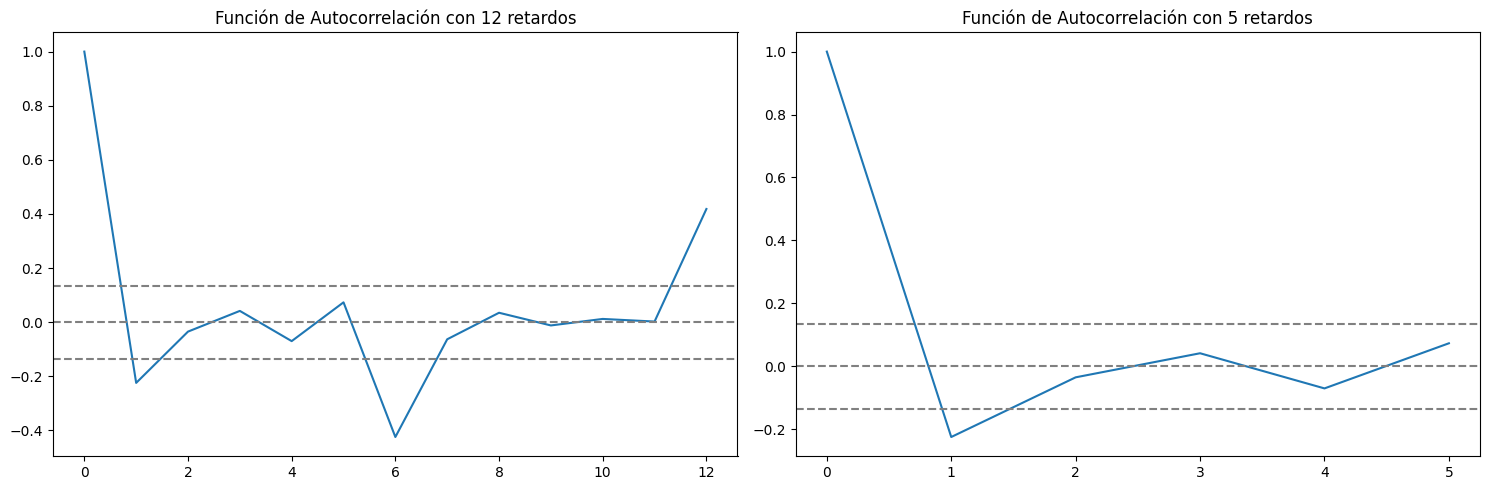

In [384]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(Gasd_df_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(Gasd_df_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

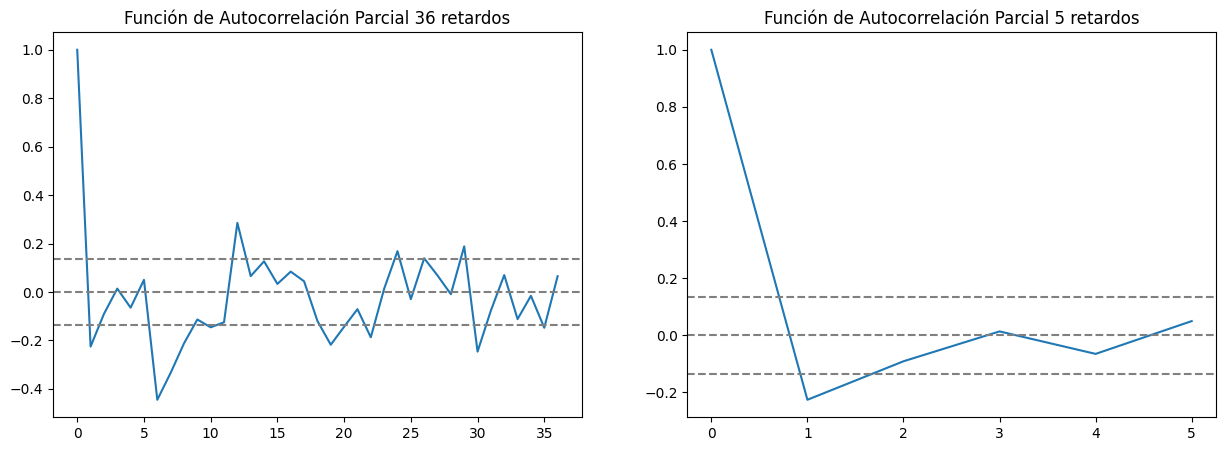

In [385]:
plt.subplot(121)
plt.plot(pacf(Gasd_df_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(Gasd_df_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Estacionalidad

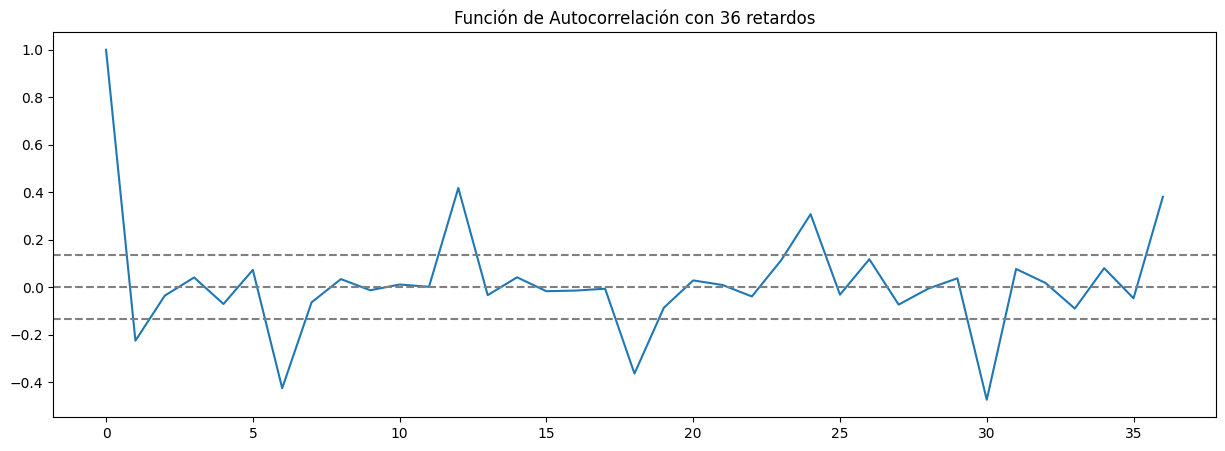

In [386]:
plt.plot(acf(Gasd_df_log_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

No parece haber una estacionalidad clara.

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 10 retardos')

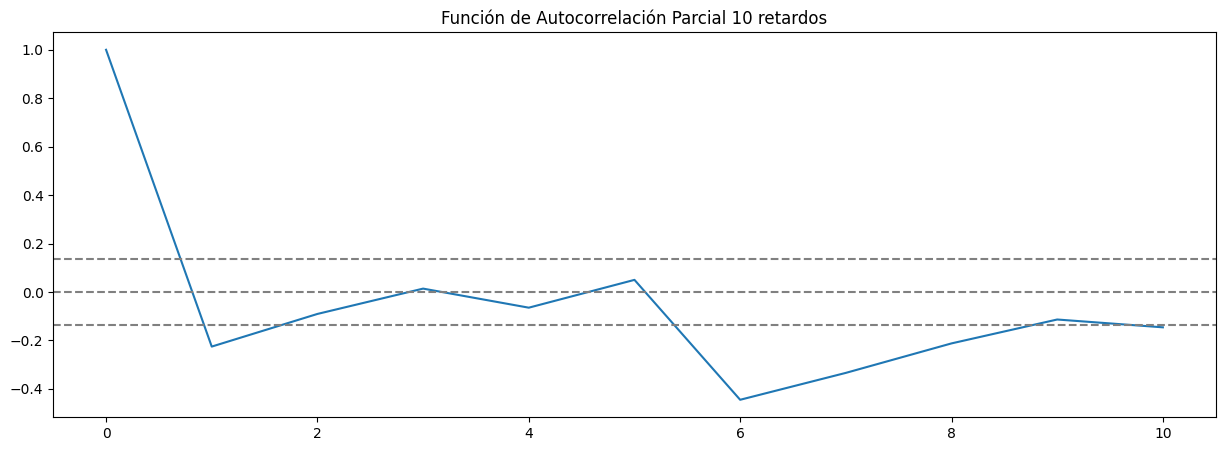

In [387]:
plt.plot(pacf(Gasd_df_log_diff, nlags=10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Gasd_df_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 10 retardos')

Despues de p = 0, salvo por p = 5 se anulan los coeficientes

In [388]:
modelo010 = SARIMAX(Gasd_df_log, order=(0,1,0), enforce_stationarity=False, enforce_invertibility=False)
resultado_m010 = modelo010.fit()
print(resultado_m010.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0102      0.001     12.099      0.000       0.009       0.012


C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


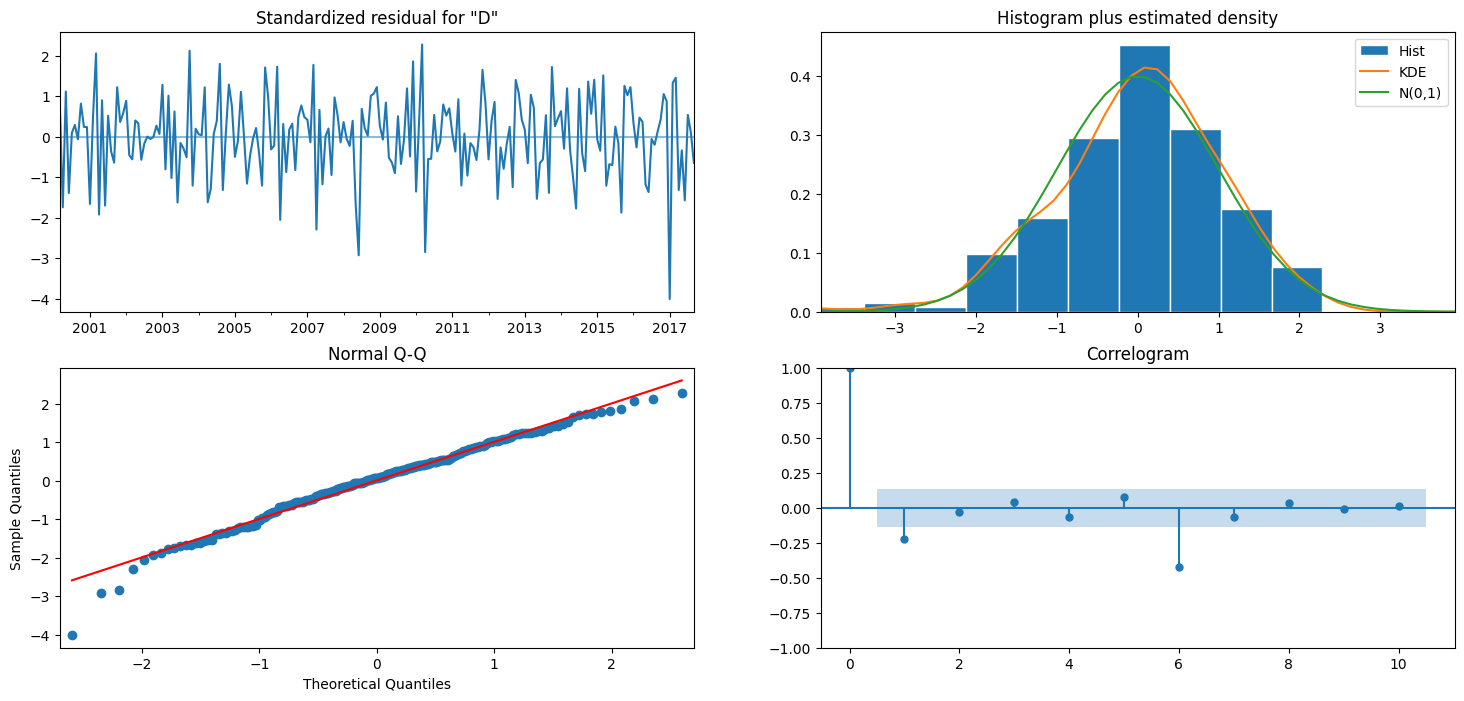

In [389]:

resultado_m010.plot_diagnostics(figsize=(18, 8))
plt.show()

In [390]:
modelo510 = SARIMAX(Gasd_df_log, order=(5,1,0), enforce_stationarity=False, enforce_invertibility=False)
resultado_m510 = modelo510.fit()
print(resultado_m510.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2222      0.068     -3.263      0.001      -0.356      -0.089
ar.L2         -0.1004      0.084     -1.196      0.232      -0.265       0.064
ar.L3          0.0066      0.086      0.076      0.939      -0.162       0.176
ar.L4         -0.0525      0.085     -0.621      0.535      -0.218       0.113
ar.L5          0.0506      0.067      0.759      0.448      -0.080       0.181
sigma2         0.0094      0.001     10.888      0.000       0.008       0.011


C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


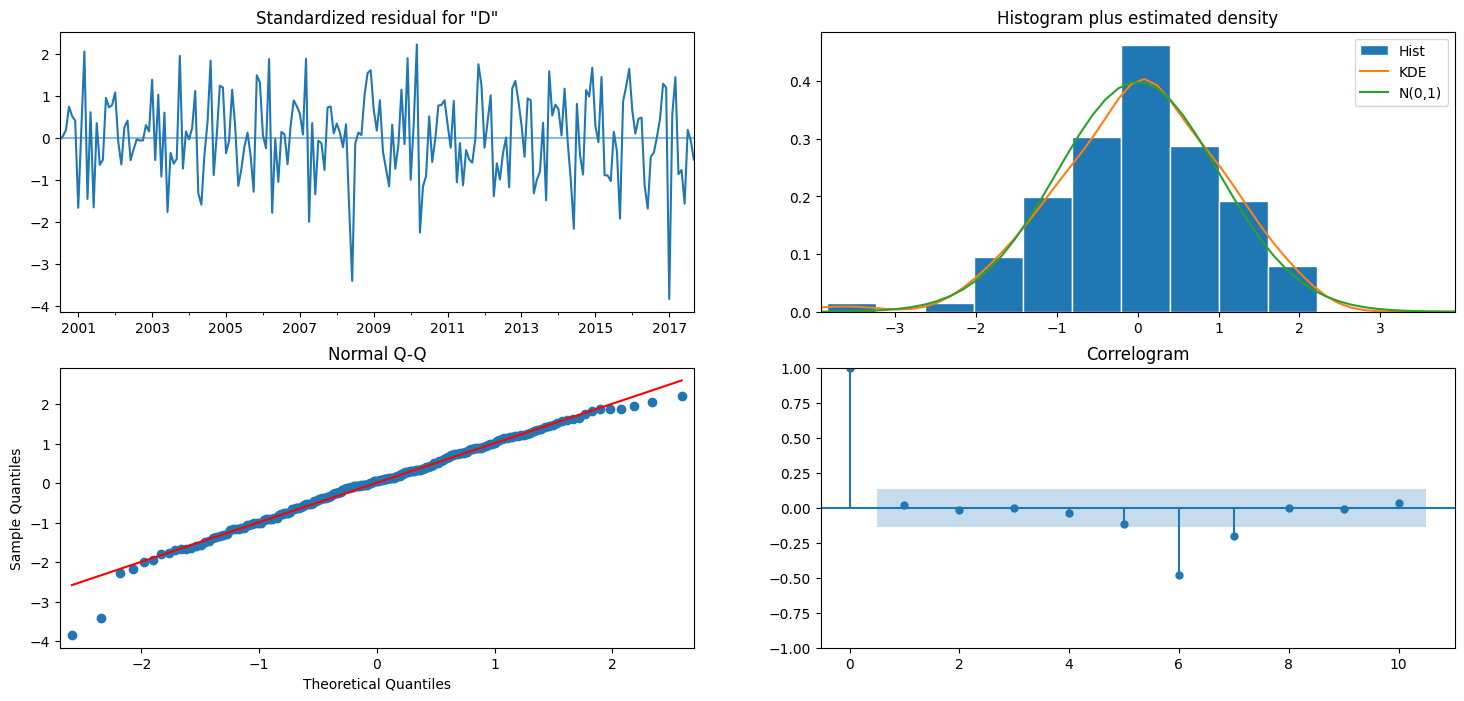

In [391]:
resultado_m510.plot_diagnostics(figsize=(18, 8))
plt.show()

In [392]:
modelo511 = SARIMAX(Gasd_df_log, order=(5,1,1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m511 = modelo511.fit()
print(resultado_m511.summary().tables[1])

C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ASUS TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7365      0.282     -2.610      0.009      -1.289      -0.183
ar.L2         -0.2175      0.116     -1.883      0.060      -0.444       0.009
ar.L3         -0.0320      0.119     -0.269      0.788      -0.265       0.201
ar.L4         -0.0270      0.100     -0.270      0.787      -0.223       0.169
ar.L5          0.1286      0.086      1.500      0.134      -0.039       0.297
ma.L1          0.5439      0.284      1.917      0.055      -0.012       1.100
sigma2         0.0091      0.001     10.923      0.000       0.007       0.011


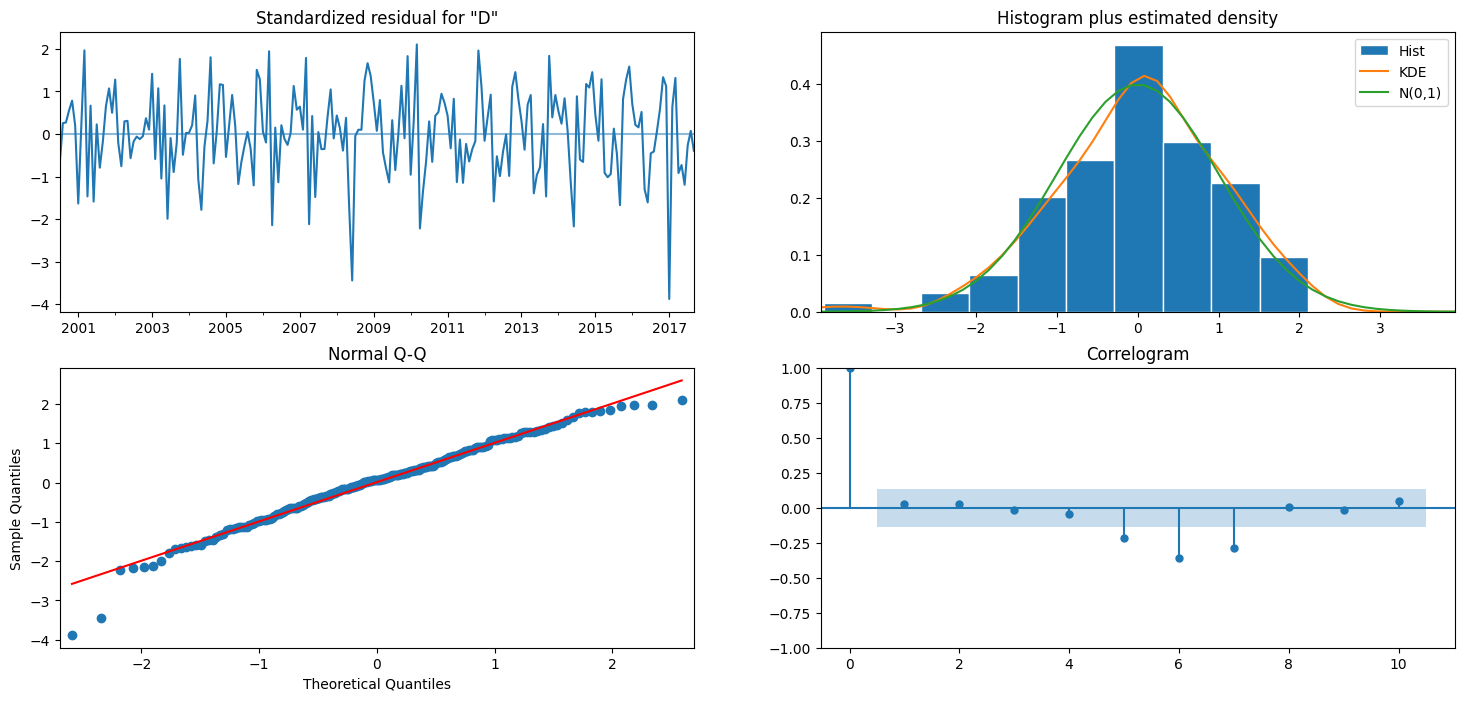

In [393]:
resultado_m511.plot_diagnostics(figsize=(18, 8))
plt.show()

In [394]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 010=",resultado_m010.aic)
print("Modelo 510=",resultado_m510.aic)
print("Modelo 511=",resultado_m511.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 010=",resultado_m010.bic)
print("Modelo 510=",resultado_m510.bic)
print("Modelo 511=",resultado_m511.bic)

Resultados de AIC (Akaike information criterion)
Modelo 010= -367.1450797399745
Modelo 510= -365.7918399939311
Modelo 511= -370.33142598700783
Resultados de BIC (Bayesian information criterion)
Modelo 010= -363.79322160649843
Modelo 510= -345.79552723433886
Modelo 511= -347.00239443415023


De acuerdo a los indicadores se elegira el modelo p = 0, d = 1, q = 0 dado que aunque el 511 dio mejores resultados de acuerdo al AIC tambien fue el de menor rendimiento de acuerdo al BIC. Mientras que el 010 tuvo un buen desempeno bajo los 2 criterios.